In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import scipy.stats as stats
import sys
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from hmmlearn import hmm

Using TensorFlow backend.


In [2]:
#Define the model evaluation metric function
def MSE(a, b):
    c=a-b
    d=c*c
    sum =np.mean(d)
    return sum
def MADE(a,b):
    c=a-b
    d=abs(c)
    sum=np.mean(d)
    return sum

In [3]:
#Read data
data=pd.read_excel(r"C:\Users\LX\Desktop\时间序列\案例分析报告\usunemployment.xlsx")
data.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1948,3.4,3.8,4.0,3.9,3.5,3.6,3.6,3.9,3.8,3.7,3.8,4.0
1,1949,4.3,4.7,5.0,5.3,6.1,6.2,6.7,6.8,6.6,7.9,6.4,6.6
2,1950,6.5,6.4,6.3,5.8,5.5,5.4,5.0,4.5,4.4,4.2,4.2,4.3
3,1951,3.7,3.4,3.4,3.1,3.0,3.2,3.1,3.1,3.3,3.5,3.5,3.1
4,1952,3.2,3.1,2.9,2.9,3.0,3.0,3.2,3.4,3.1,3.0,2.8,2.7


In [4]:
#Data preprocessing, format adjustment
df=pd.melt(data,id_vars=['Year'],var_name='Month',value_name='Value')
df['Date']=pd.to_datetime(df['Year'].astype(str)+'-'+df['Month']).dt.strftime('%Y-%m')
df=df.drop(['Year', 'Month'],axis=1)
df=df.sort_values('Date')
df=df.iloc[:, ::-1]
df=df.dropna(axis=0)
print(df)
df.to_excel('C:\\Users\\LX\\Desktop\\时间序列\\案例分析报告\\dataset.xlsx', index=True)

        Date  Value
0    1948-01    3.4
76   1948-02    3.8
152  1948-03    4.0
228  1948-04    3.9
304  1948-05    3.5
..       ...    ...
75   2023-01    3.4
151  2023-02    3.6
227  2023-03    3.5
303  2023-04    3.4
379  2023-05    3.7

[905 rows x 2 columns]


In [5]:
newdf=pd.read_excel(r"C:\Users\LX\Desktop\时间序列\案例分析报告\dataset.xlsx")
newdf=newdf.iloc[:,1:3]

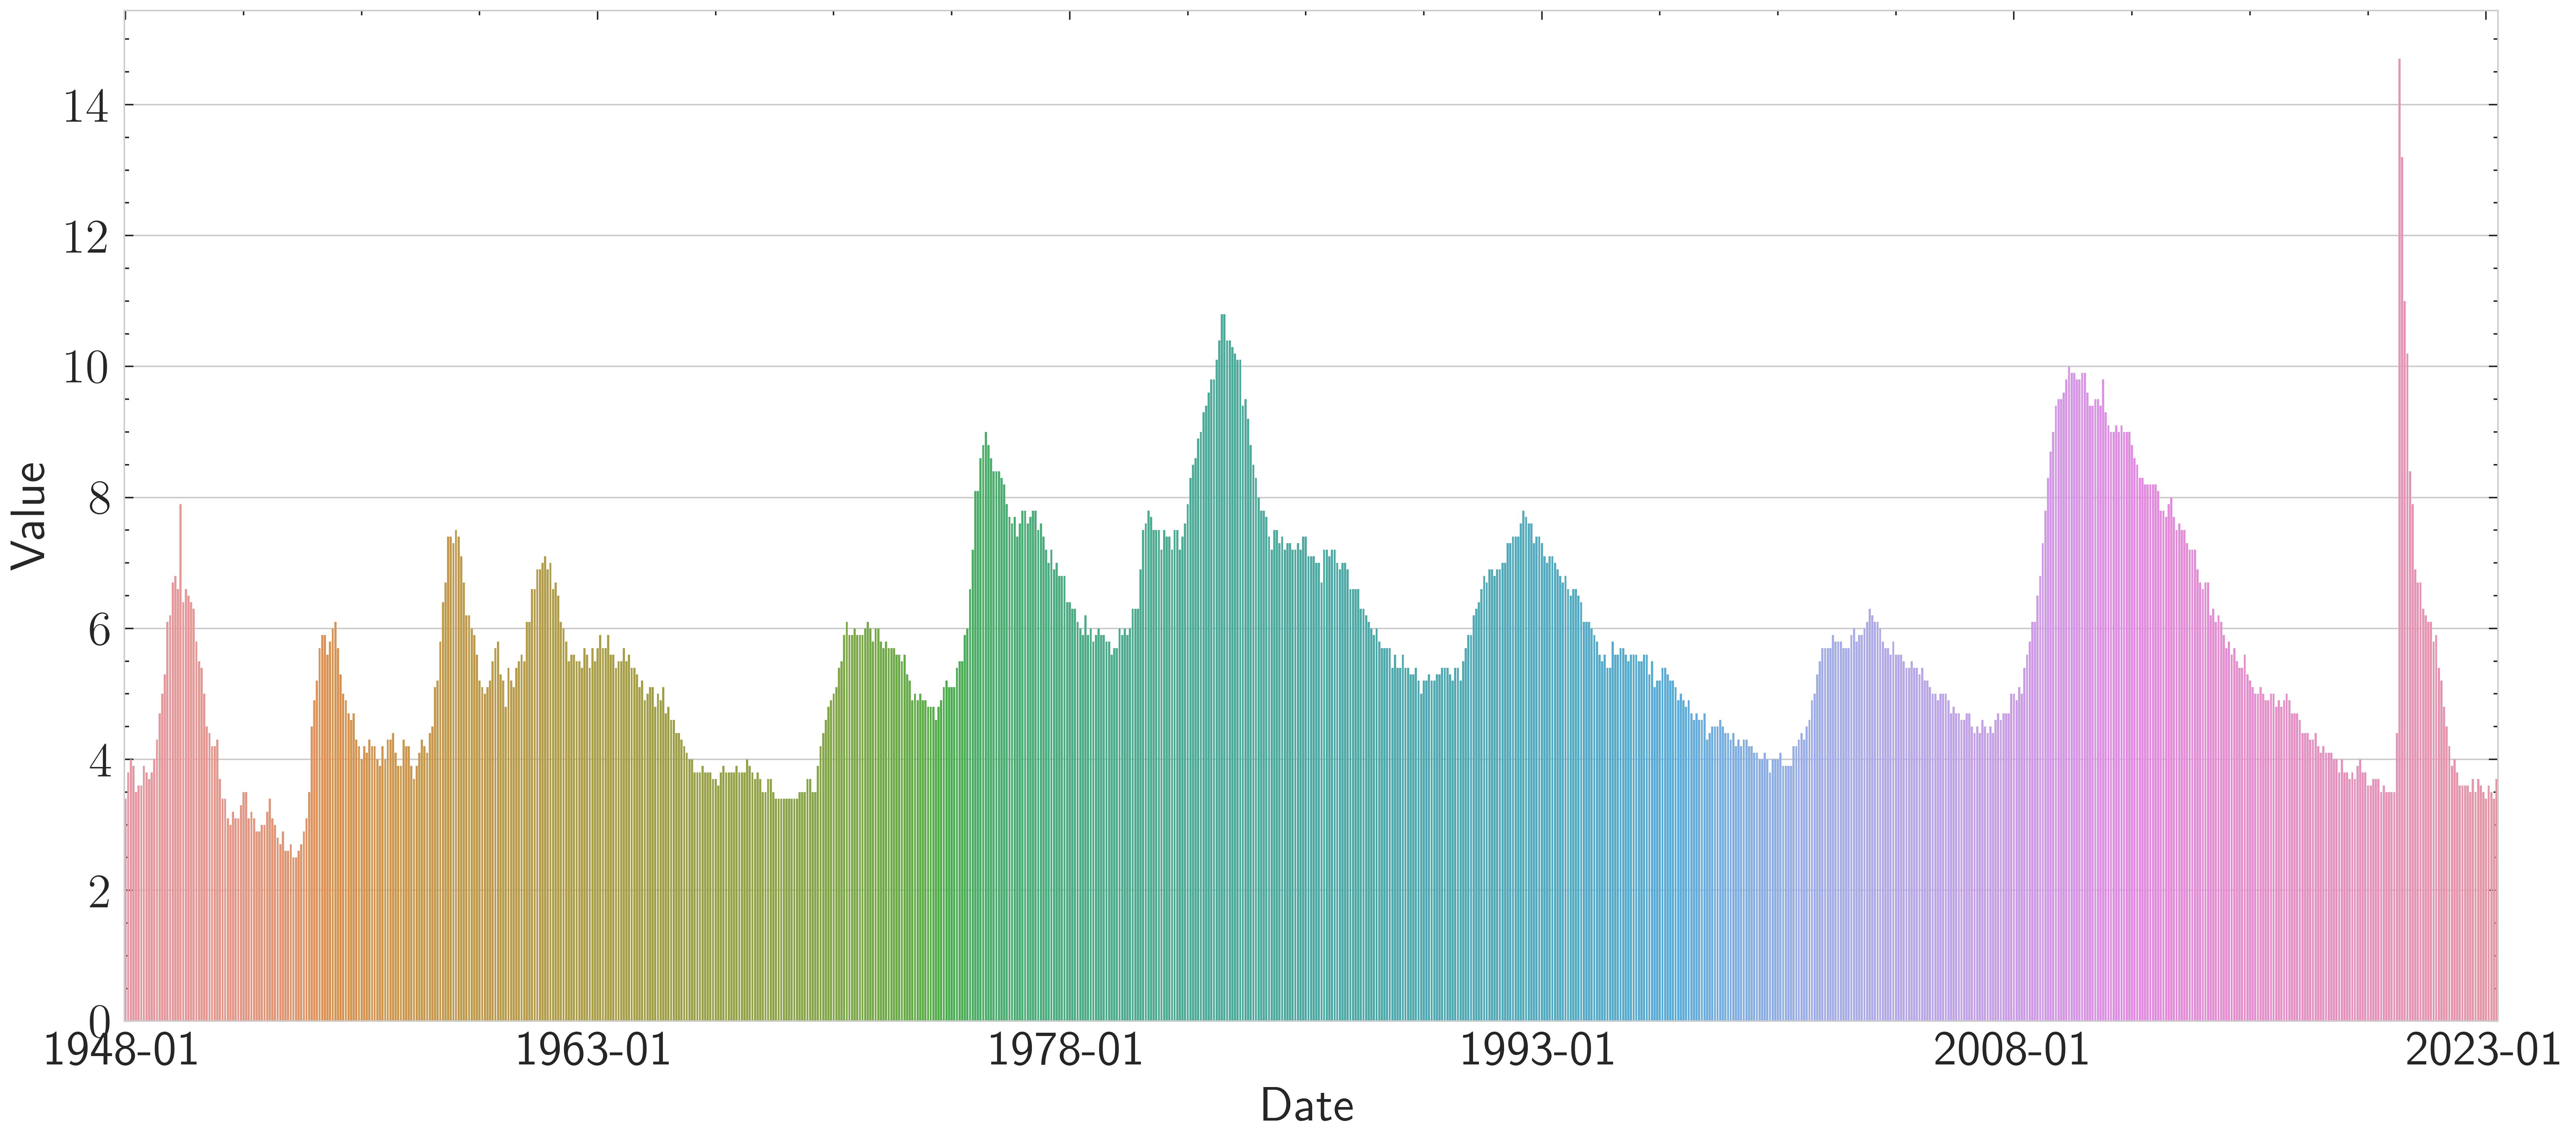

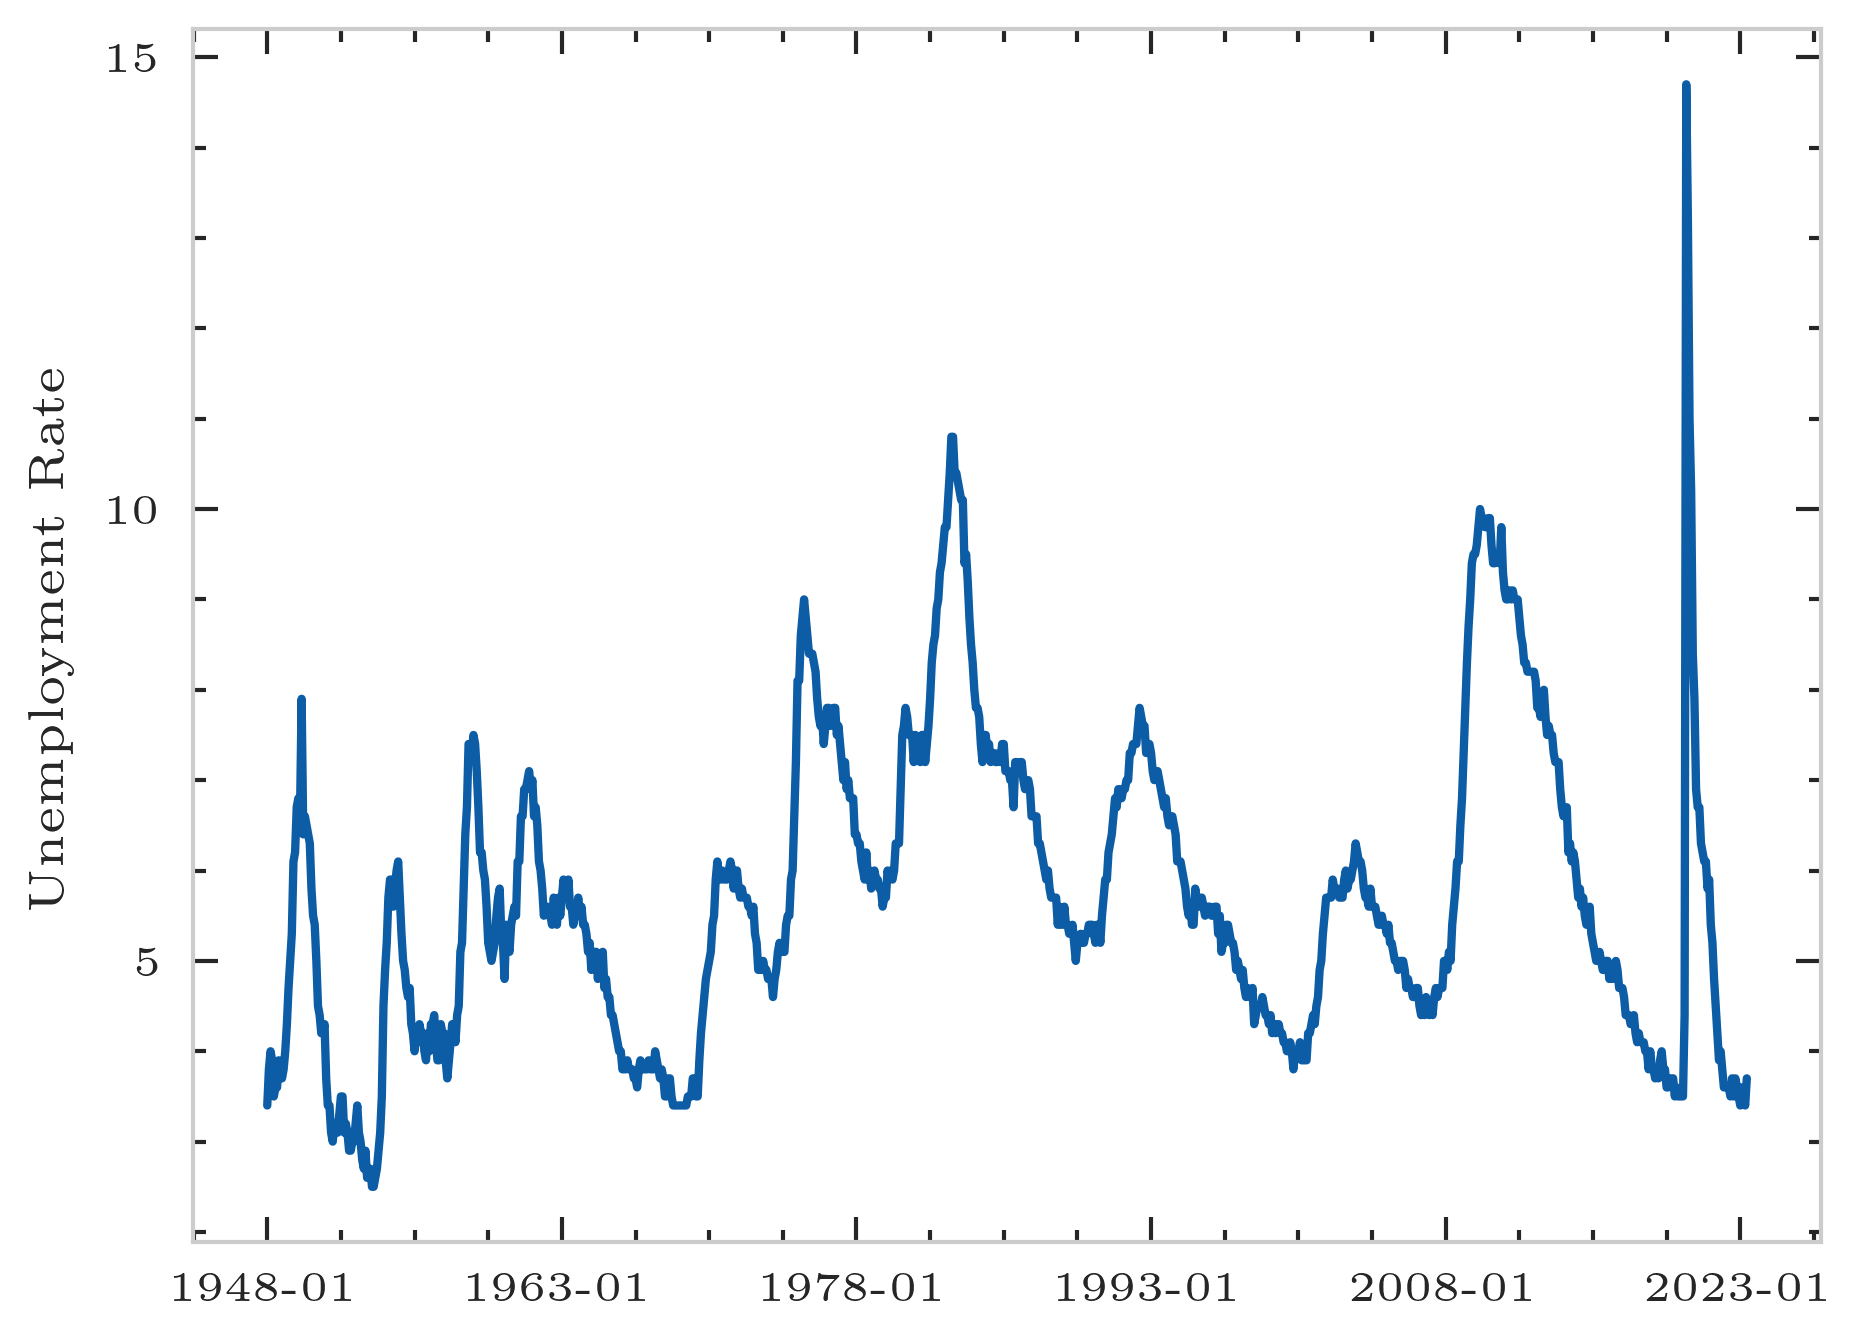

<Figure size 2100x1575 with 0 Axes>

In [61]:
#visualization
fig, ax = plt.subplots(figsize=(14,6))
sns.barplot(x='Date', y='Value', data=newdf, ax=ax)
plt.xticks(rotation=0)
plt.xticks(range(0, 905, 180))
plt.style.use('seaborn-whitegrid')
plt.show()
#line chart
plt.style.use('science')
plt.plot(newdf['Date'],newdf['Value'])
plt.grid (False)
plt.ylabel('Unemployment Rate',fontsize=6)
plt.xticks(range(0, 905, 180),fontsize=5)
plt.yticks(fontsize=5)
plt.savefig('firstdata.png', transparent=True,dpi=1000)
plt.show()
plt.clf()

## Exploratory Data Analysis（EDA）

ADF 统计量： -3.8825496799378025
p 值： 0.0021670919791207653
临界值： {'1%': -3.43761244359048, '5%': -2.8647460220589736, '10%': -2.568477099382028}


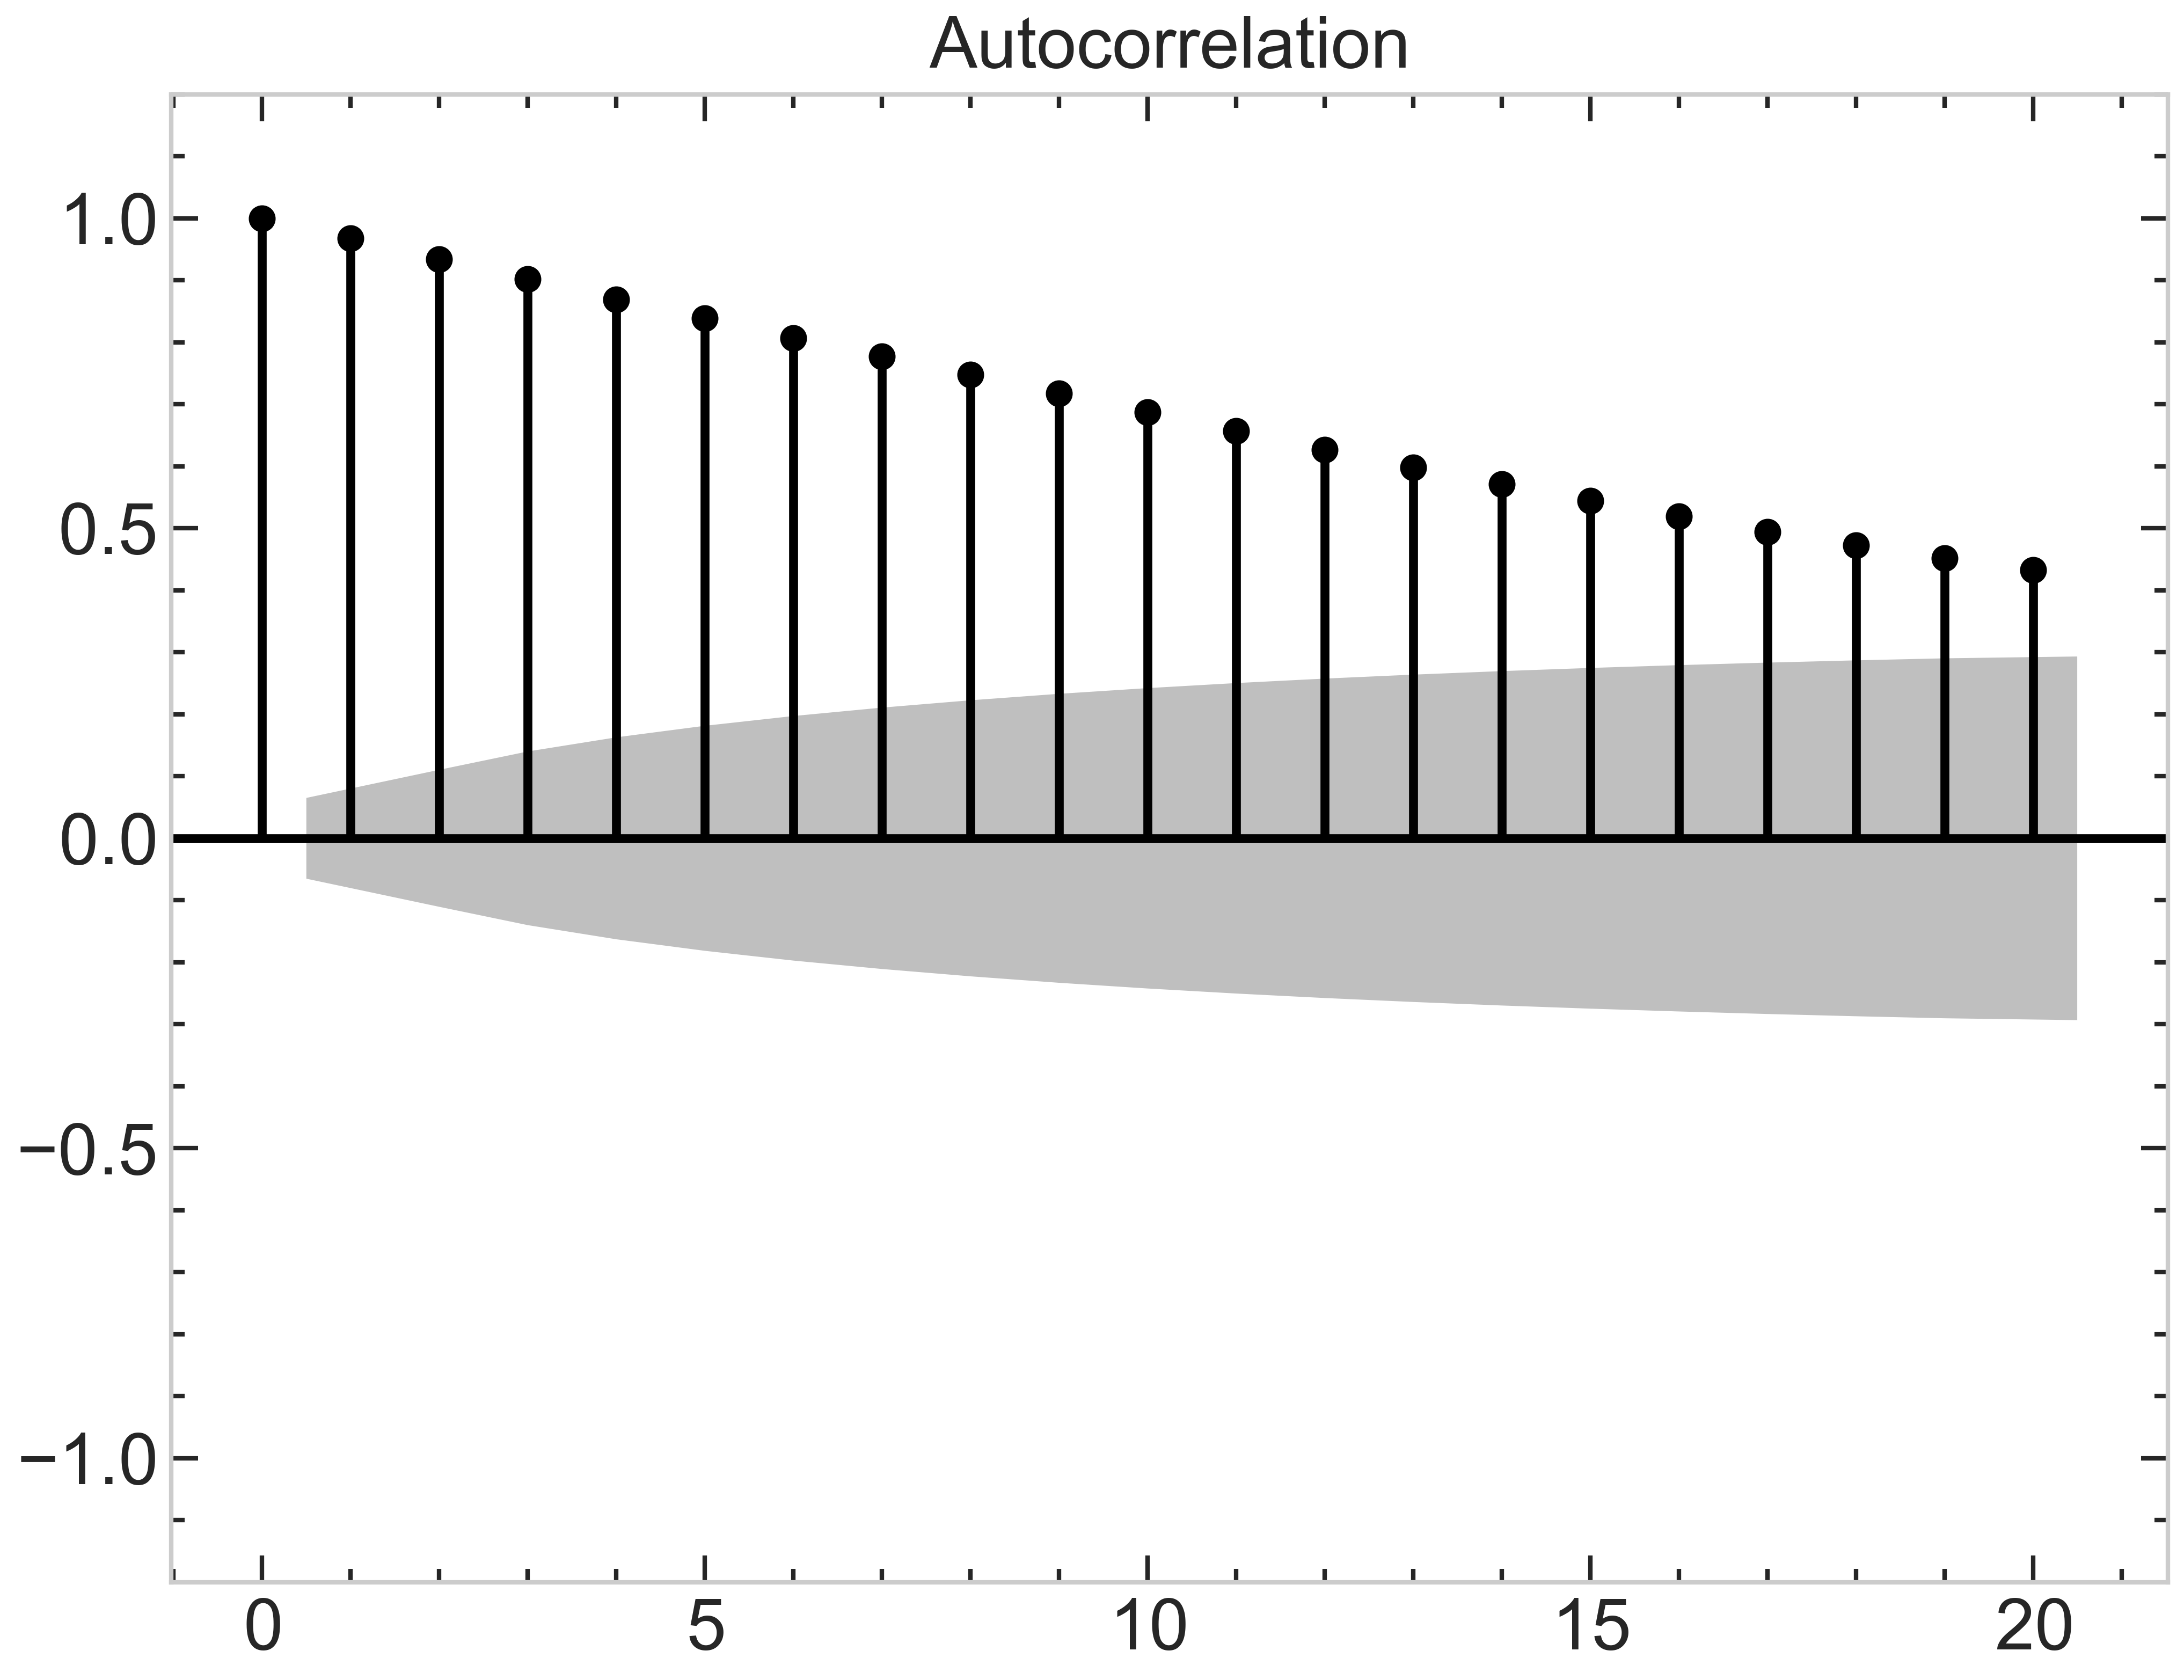

C:\Users\LX\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


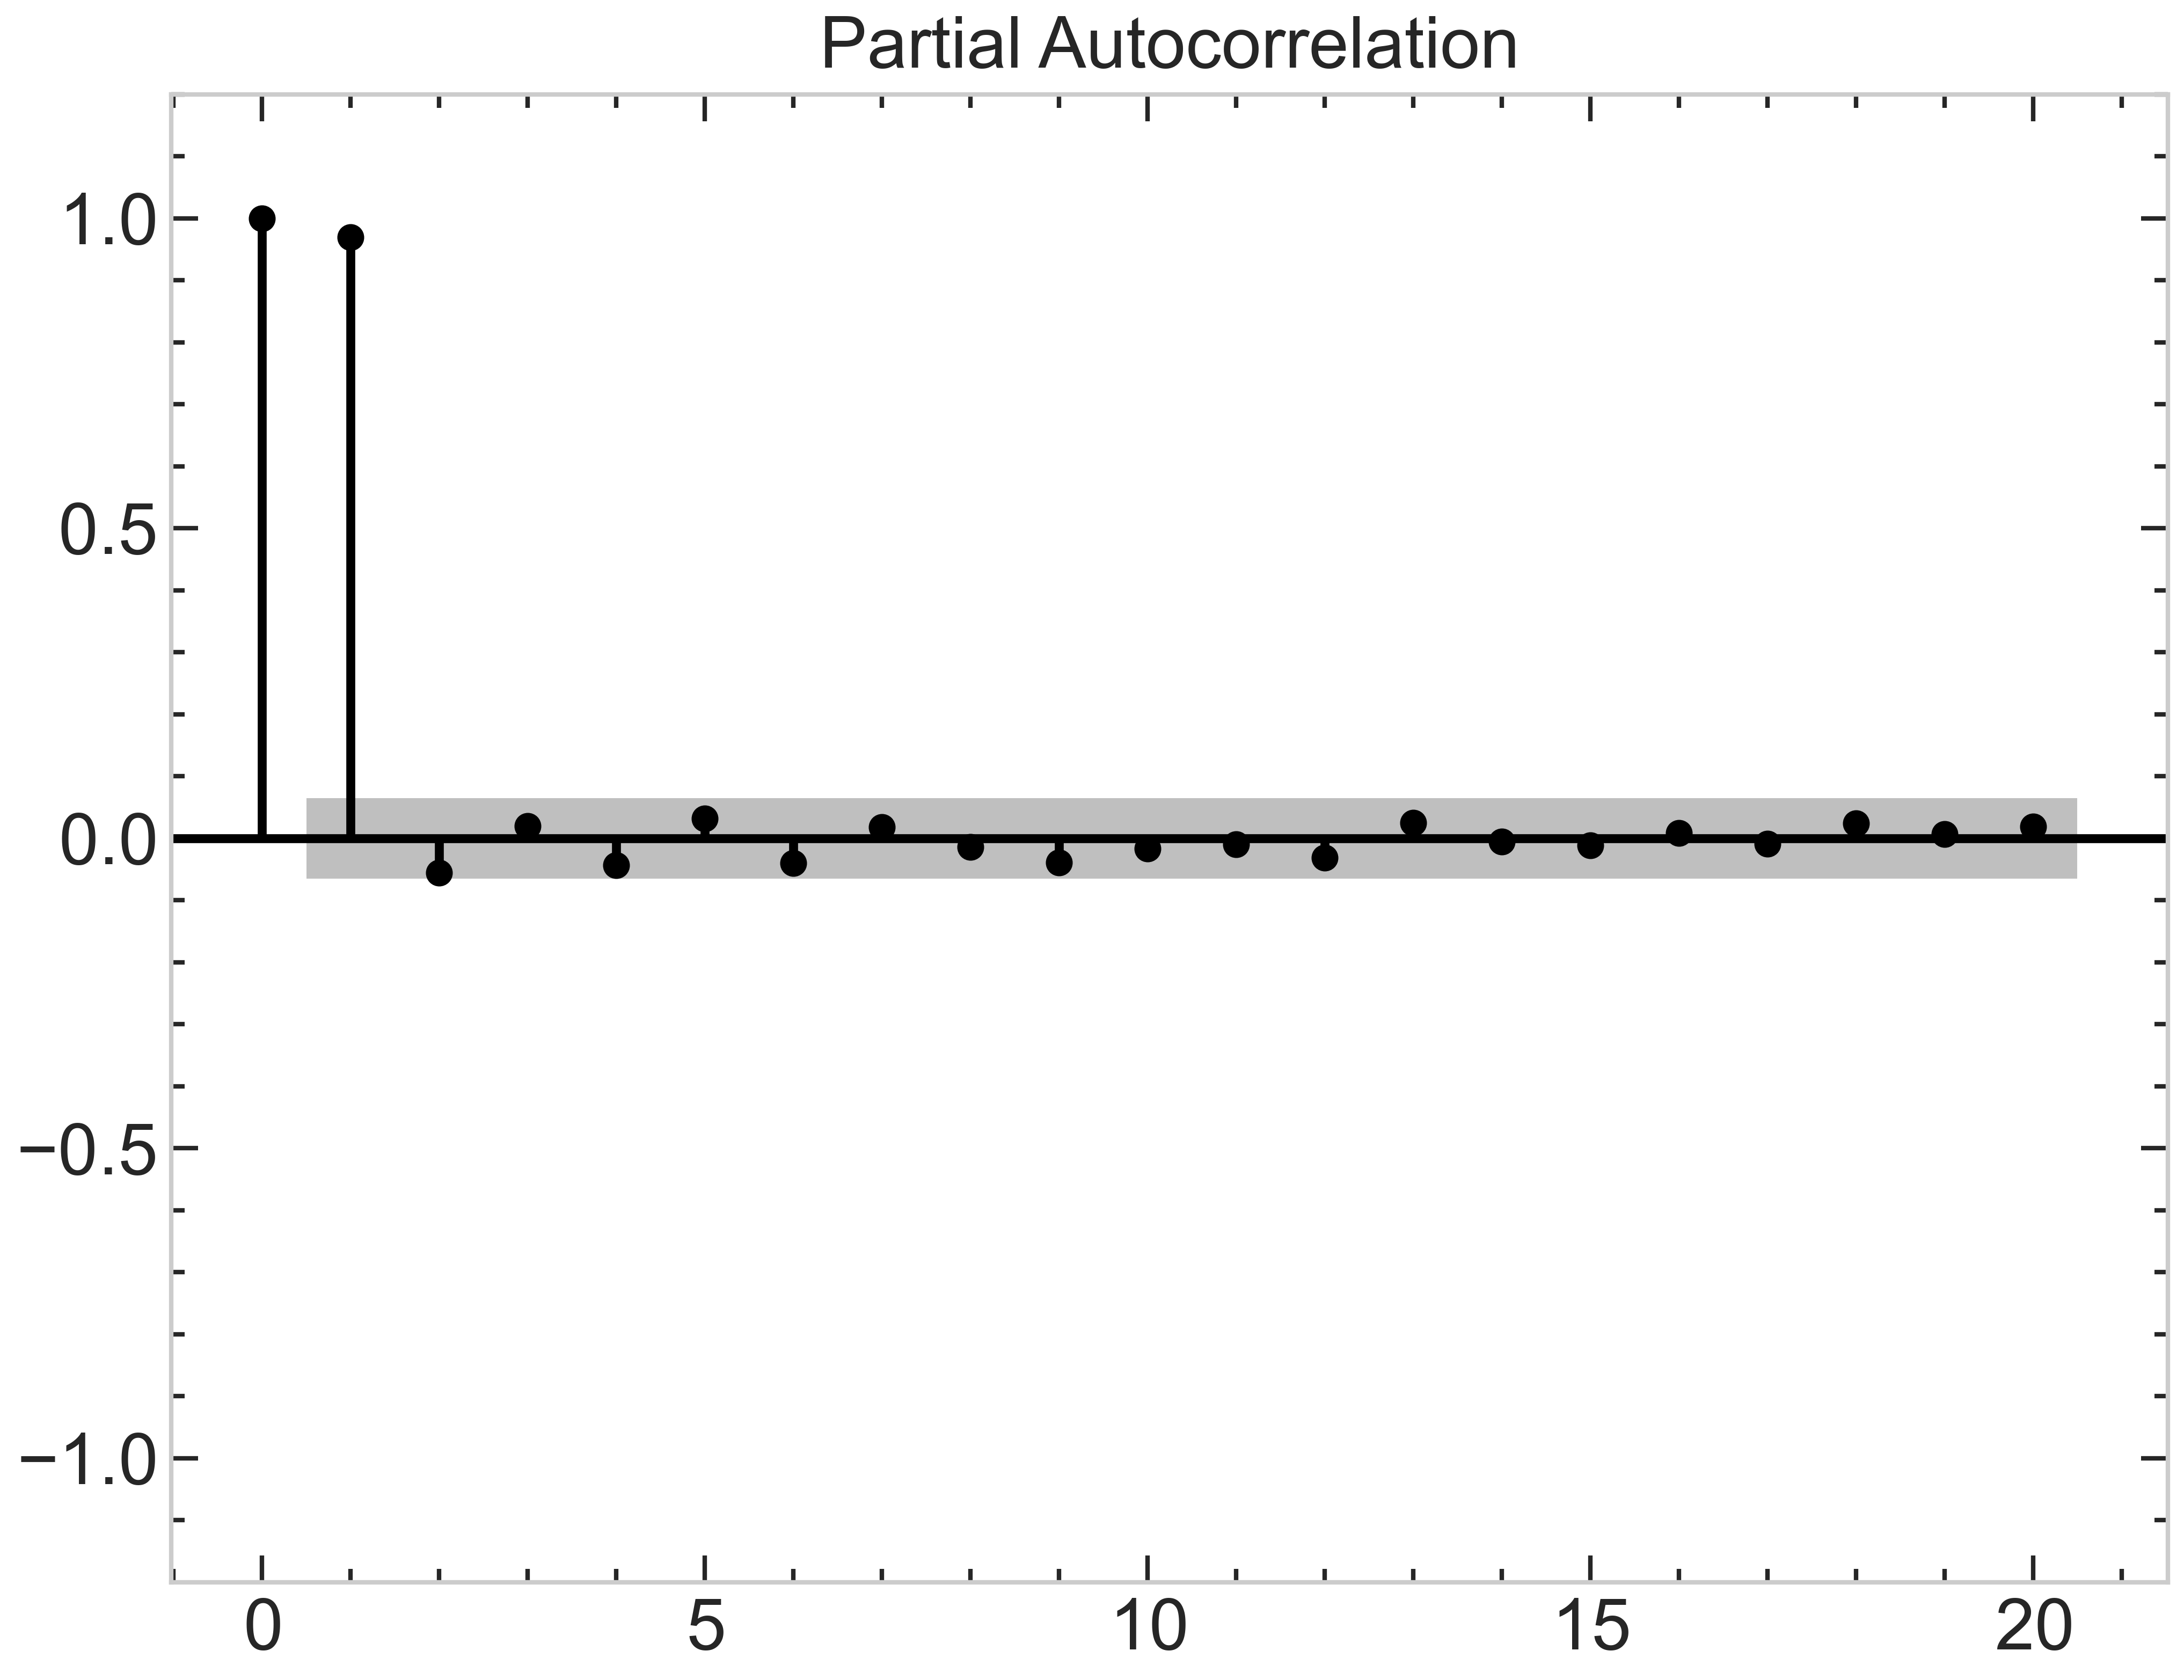

In [26]:
#stationarity test
#unit root test
result=adfuller(newdf['Value'])
print('ADF 统计量：', result[0])
print('p 值：', result[1])
print('临界值：', result[4])
#plotting ACF (AutoCorrelation Function) graph
plt.style.use(['science','ieee','notebook'])
plot_acf(newdf['Value'], lags=20)
plt.ylim(-1.2,1.2)
plt.grid (False)
plt.savefig('ACF.png', transparent=True,dpi=1000)
plt.show()
#plotting PACF (Partial AutoCorrelation Function) graph
plot_pacf(newdf['Value'], lags=20)
plt.ylim(-1.2,1.2)
plt.grid (False)
plt.savefig('PACF.png', transparent=True,dpi=1000)
plt.show()

In [41]:
# Ljung-Box test
result_ljungbox=sm.stats.acorr_ljungbox(newdf['Value'],lags=10)  # specify lag order
print('Ljung-Box检验结果：')
print('统计量：',result_ljungbox)

Ljung-Box检验结果：
统计量：         lb_stat      lb_pvalue
1    851.242258  3.903886e-187
2   1644.474714   0.000000e+00
3   2385.299234   0.000000e+00
4   3073.268241   0.000000e+00
5   3714.553967   0.000000e+00
6   4309.260679   0.000000e+00
7   4861.667535   0.000000e+00
8   5374.121288   0.000000e+00
9   5845.957693   0.000000e+00
10  6279.065860   0.000000e+00


## ARIMA

In [13]:
##model selection using AIC
data=newdf['Value']
def find_best_arima_order(data):
    p_values=range(0, 5)
    d_values=range(0, 3)
    q_values=range(0, 5)
    best_aic=float('inf')
    best_order=None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    model = sm.tsa.ARIMA(data, order=order)
                    results = model.fit()
                    aic = results.aic
                    if aic<best_aic:
                        best_aic = aic
                        best_order = order
                except:
                    continue
    return best_order
best_order=find_best_arima_order(data)
print("best order for ARIMA:",best_order)

C:\Users\LX\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\LX\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\LX\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\LX\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\LX\AppData\Local\Programs\Pyth

最佳ARIMA阶数: (2, 0, 1)


C:\Users\LX\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [6]:
#train
model=ARIMA(newdf['Value'],order=(2,0,1))
model_fit=model.fit()

In [7]:
#get the fitted values
arima_fitted_values=model_fit.fittedvalues

In [8]:
#model evaluation
print("arimaMSE=",round(MSE(newdf['Value'],arima_fitted_values),4))
print("arimaMADE=",round(MADE(newdf['Value'],arima_fitted_values),4))

arimaMSE= 0.1757
arimaMADE= 0.1753


In [9]:
#performing sequence forecasting
forecast=model_fit.get_forecast(steps=60)
arima_predicted_values=forecast.predicted_mean

In [10]:
#residual analysis
print(model_fit.summary())
residuals = model_fit.resid

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  905
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -485.736
Date:                Tue, 27 Jun 2023   AIC                            981.471
Time:                        13:34:48   BIC                           1005.511
Sample:                             0   HQIC                           990.652
                                - 905                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5804      0.748      7.464      0.000       4.115       7.046
ar.L1          0.2317      0.098      2.365      0.018       0.040       0.424
ar.L2          0.7141      0.102      7.023      0.0

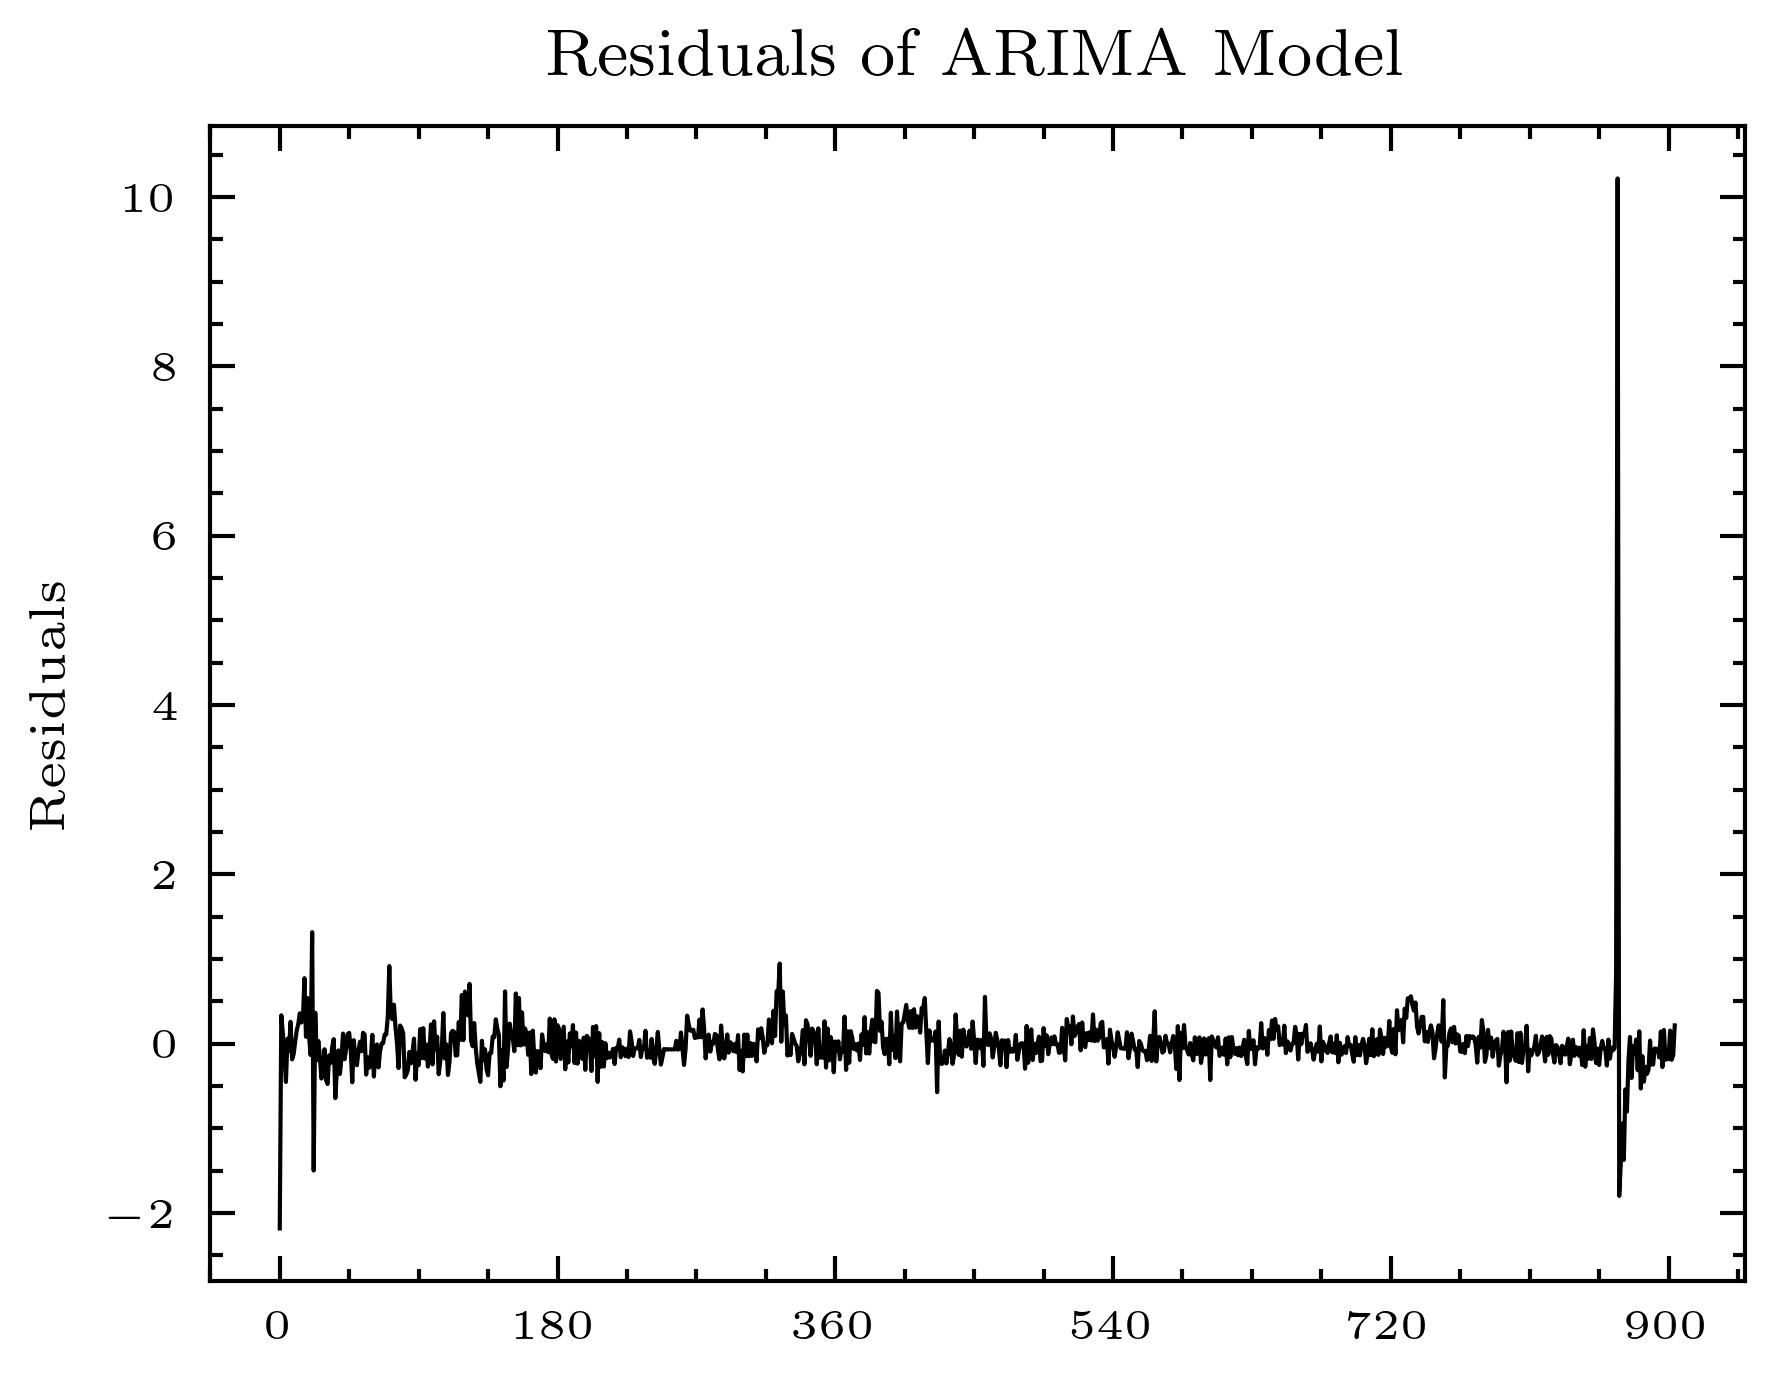

<Figure size 1980x1500 with 0 Axes>

In [11]:
# plot residual sequence graph
plt.style.use(['science','ieee'])
plt.grid (False)
plt.plot(residuals,linewidth=0.5)
plt.title('Residuals of ARIMA Model',fontsize=8)
plt.ylabel('Residuals',fontsize=6)
plt.xticks(range(0, 905, 180),rotation=0,fontsize=5)
plt.yticks(fontsize=5)
plt.savefig('residual.png', transparent=True,dpi=1000)
plt.show()
plt.clf()

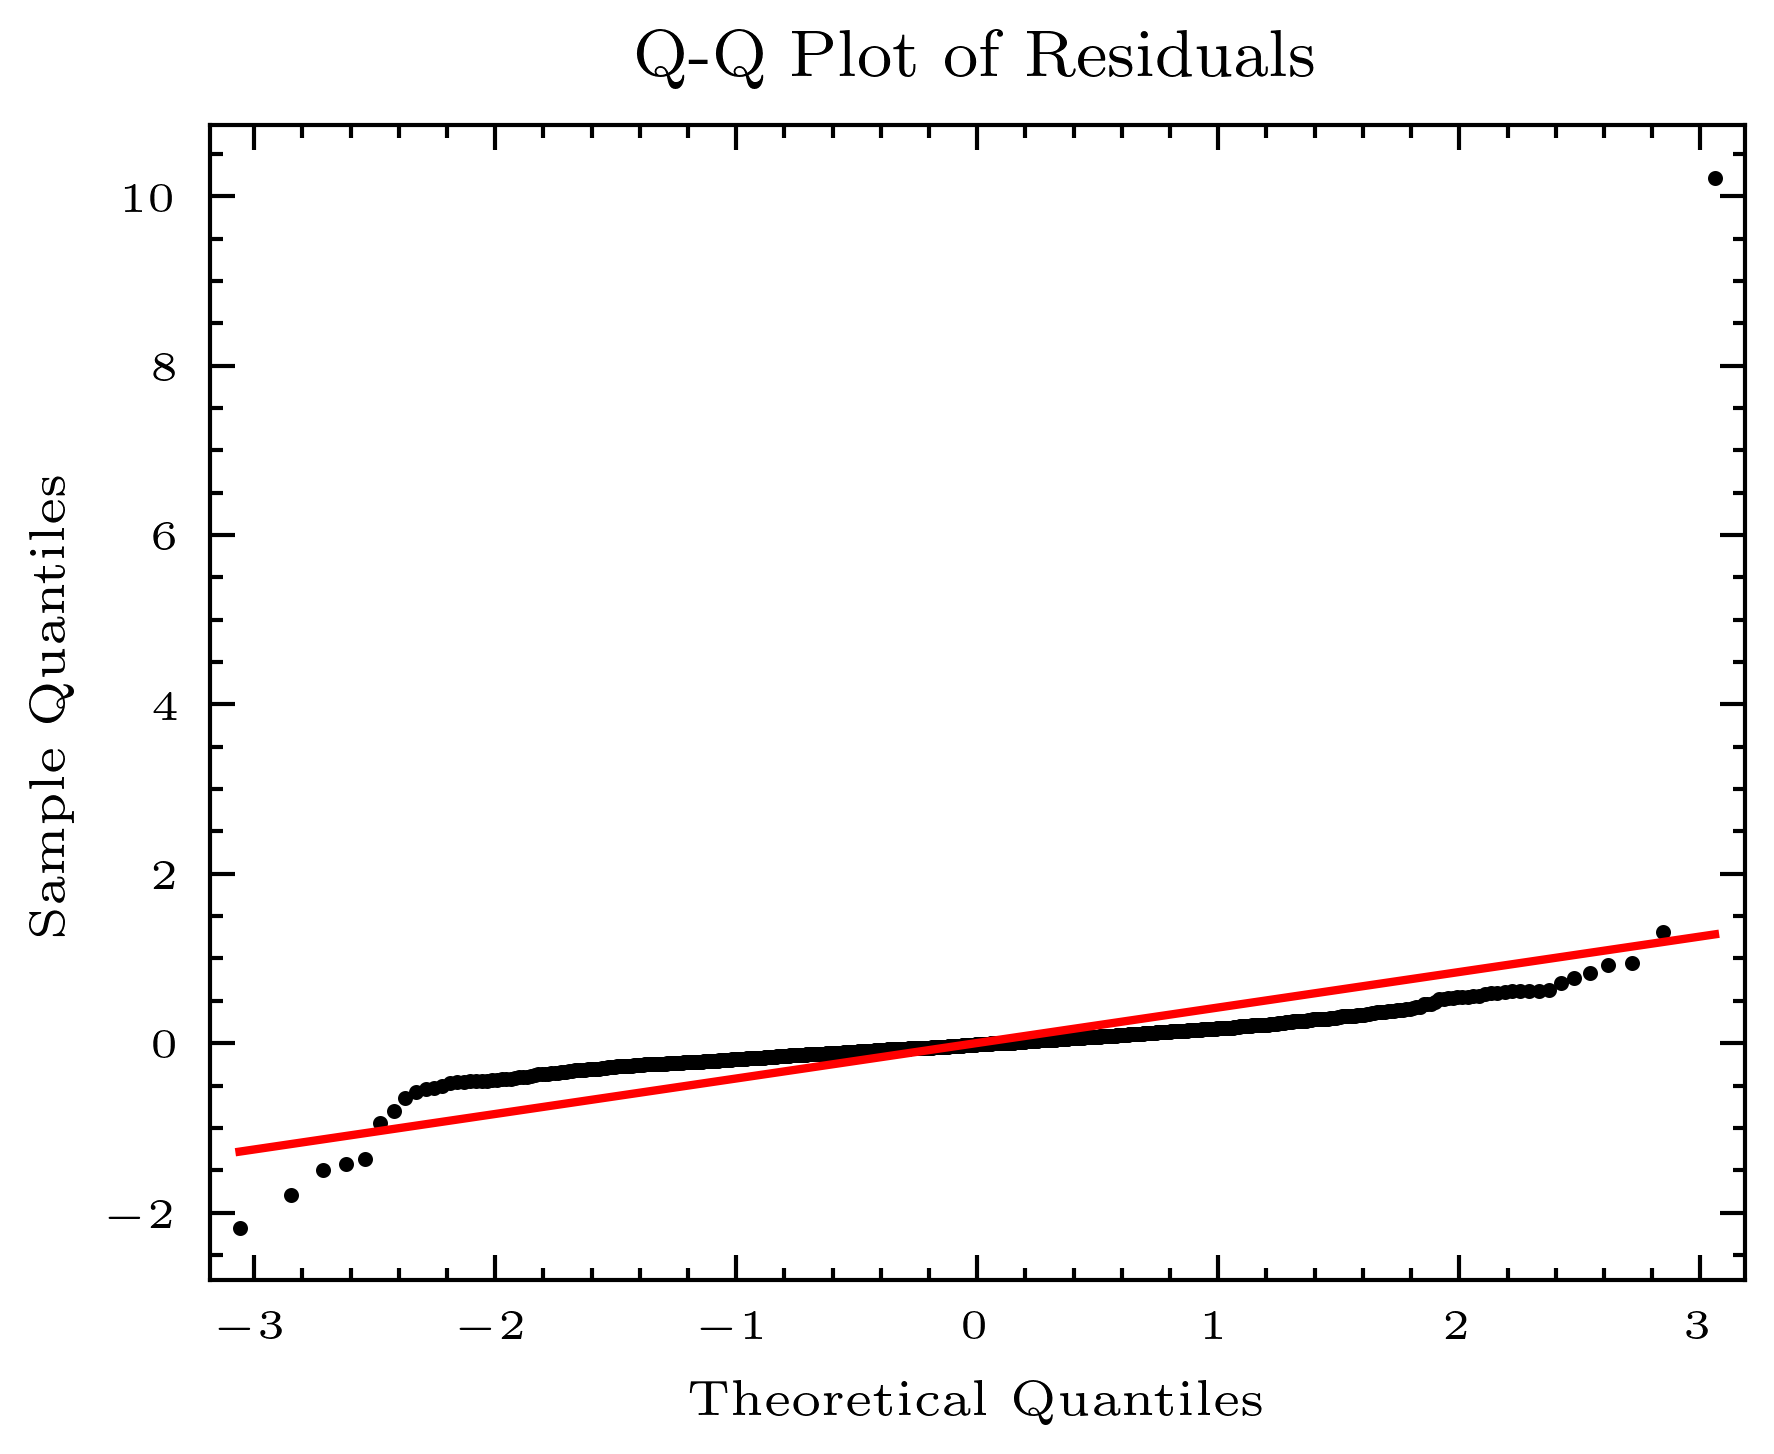

<Figure size 1980x1500 with 0 Axes>

In [12]:
# plot residual Q-Q plot
plt.style.use(['science','ieee'])
sm.qqplot(residuals, line='s',linewidth=2.0,marker='o', markersize=0.8)
plt.grid (False)
plt.title('Q-Q Plot of Residuals',fontsize=8)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
plt.ylabel('Sample Quantiles',fontsize=6)
plt.xlabel('Theoretical Quantiles',fontsize=6)
plt.savefig('residualQQ.png', transparent=True,dpi=1000)
plt.show()
plt.clf()

In [13]:
#normality
statistic, p_value = stats.shapiro(residuals)
print("Kolmogorov-Smirnov Test:")
print("Statistic:", statistic)
print("p-value:", p_value)
#white noise test for residual sequence
rrresult_ljungbox=sm.stats.acorr_ljungbox(residuals,lags=10)  # specify lag order
print('result for Ljung-Box test：')
print('statistic：',rrresult_ljungbox)

Kolmogorov-Smirnov Test:
Statistic: 0.4008216857910156
p-value: 0.0
Ljung-Box检验结果：
统计量：      lb_stat  lb_pvalue
1   0.005170   0.942677
2   0.346964   0.840732
3   0.436919   0.932515
4   0.559523   0.967454
5   0.785681   0.977938
6   0.790791   0.992318
7   0.806944   0.997372
8   2.359747   0.967951
9   2.385603   0.983803
10  2.410971   0.992111


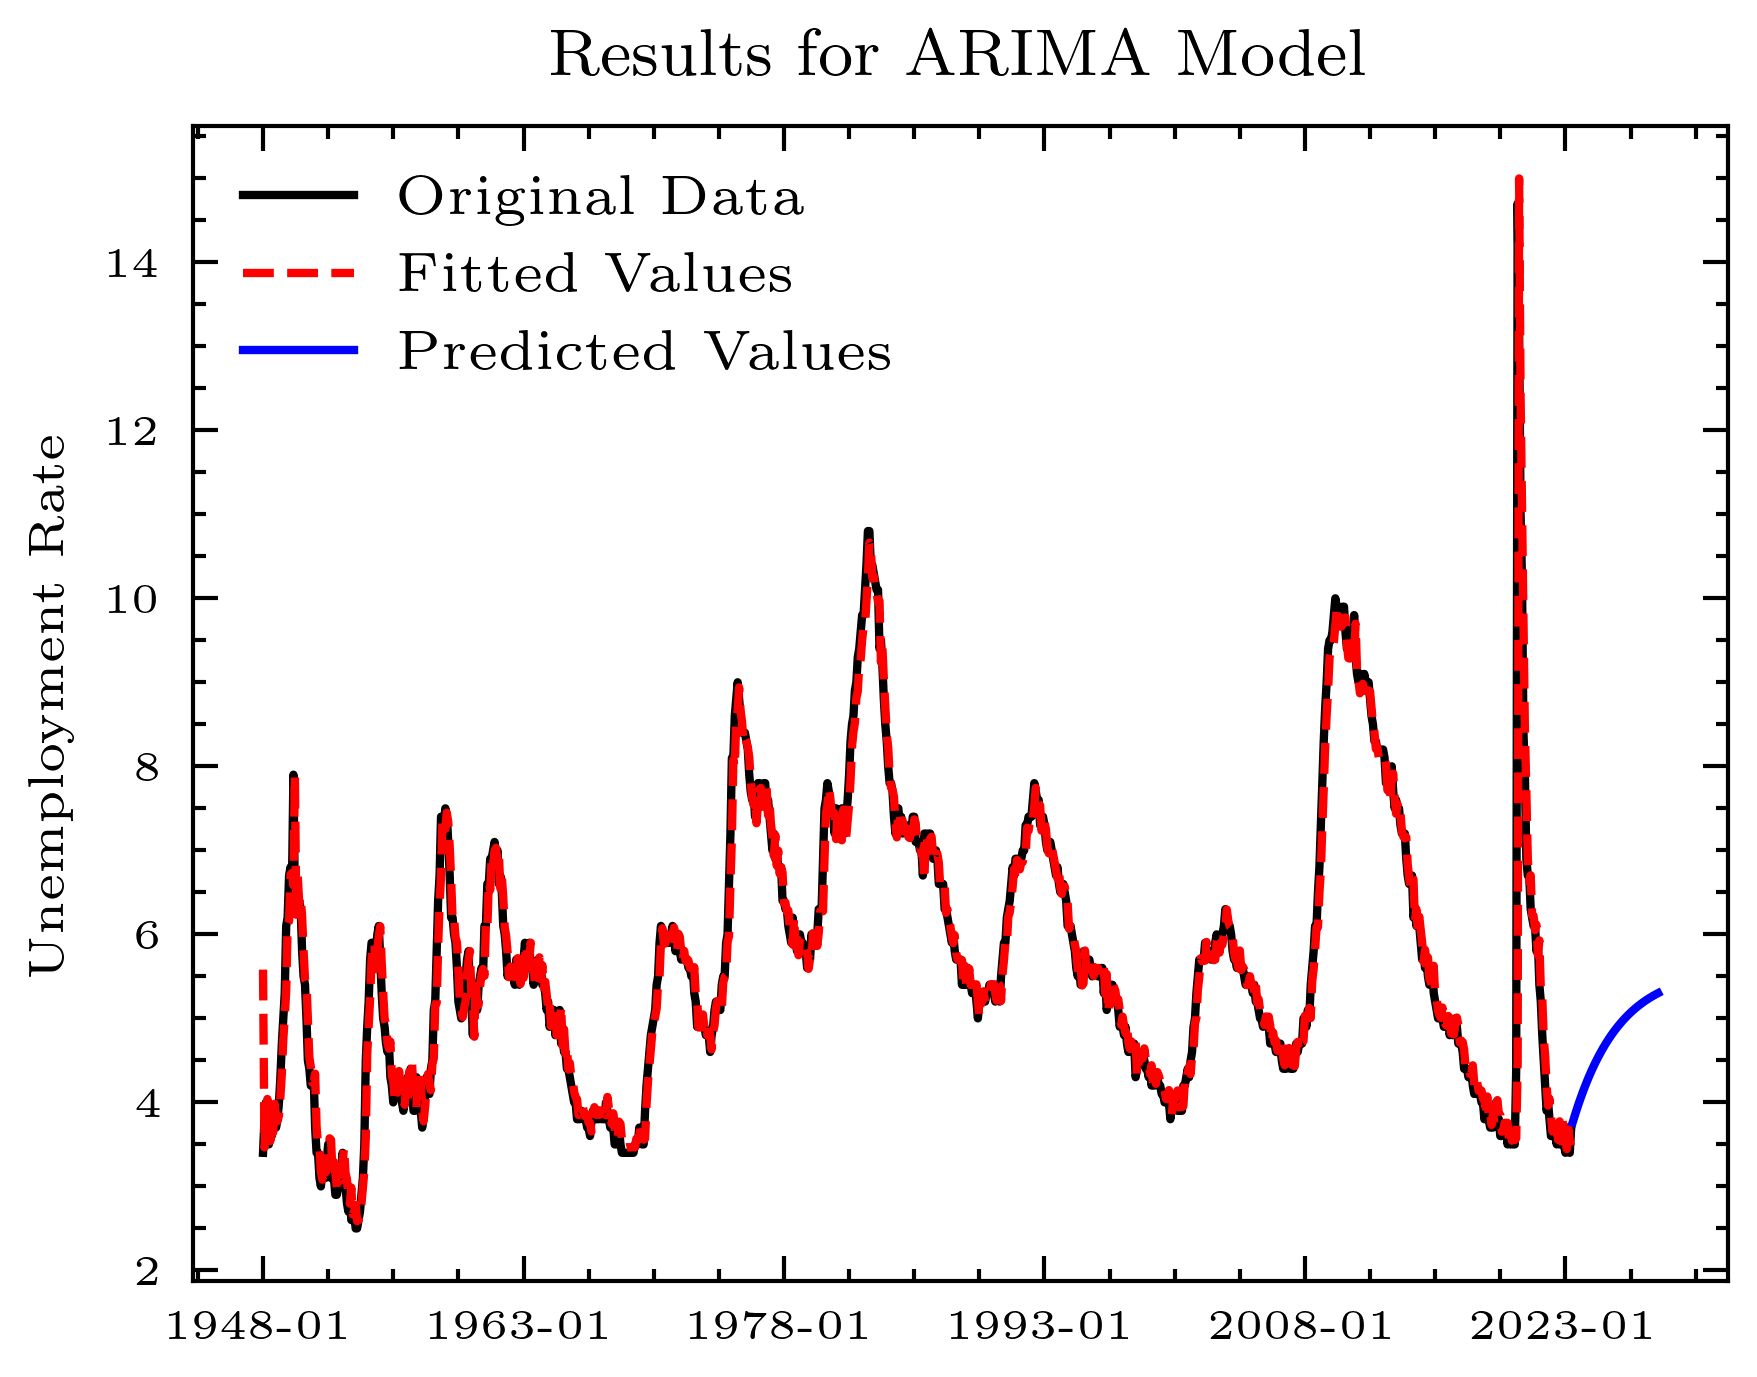

In [45]:
#Visualization
plt.style.use(['science','ieee'])
plt.grid (False)
plt.plot(newdf['Date'],newdf['Value'], label='Original Data')
plt.plot(arima_fitted_values, label='Fitted Values')
plt.plot(arima_predicted_values, label='Predicted Values',linestyle='-')
plt.xticks(range(0, 905, 180),rotation=0,fontsize=5)
plt.yticks(fontsize=5)
plt.ylabel('Unemployment Rate',fontsize=6)
plt.legend(fontsize='small')
plt.title('Results for ARIMA Model',fontsize=8)
plt.savefig('ARIMA.png', transparent=True,dpi=1000)
plt.show()

## Hidden Markov Model（HMM）

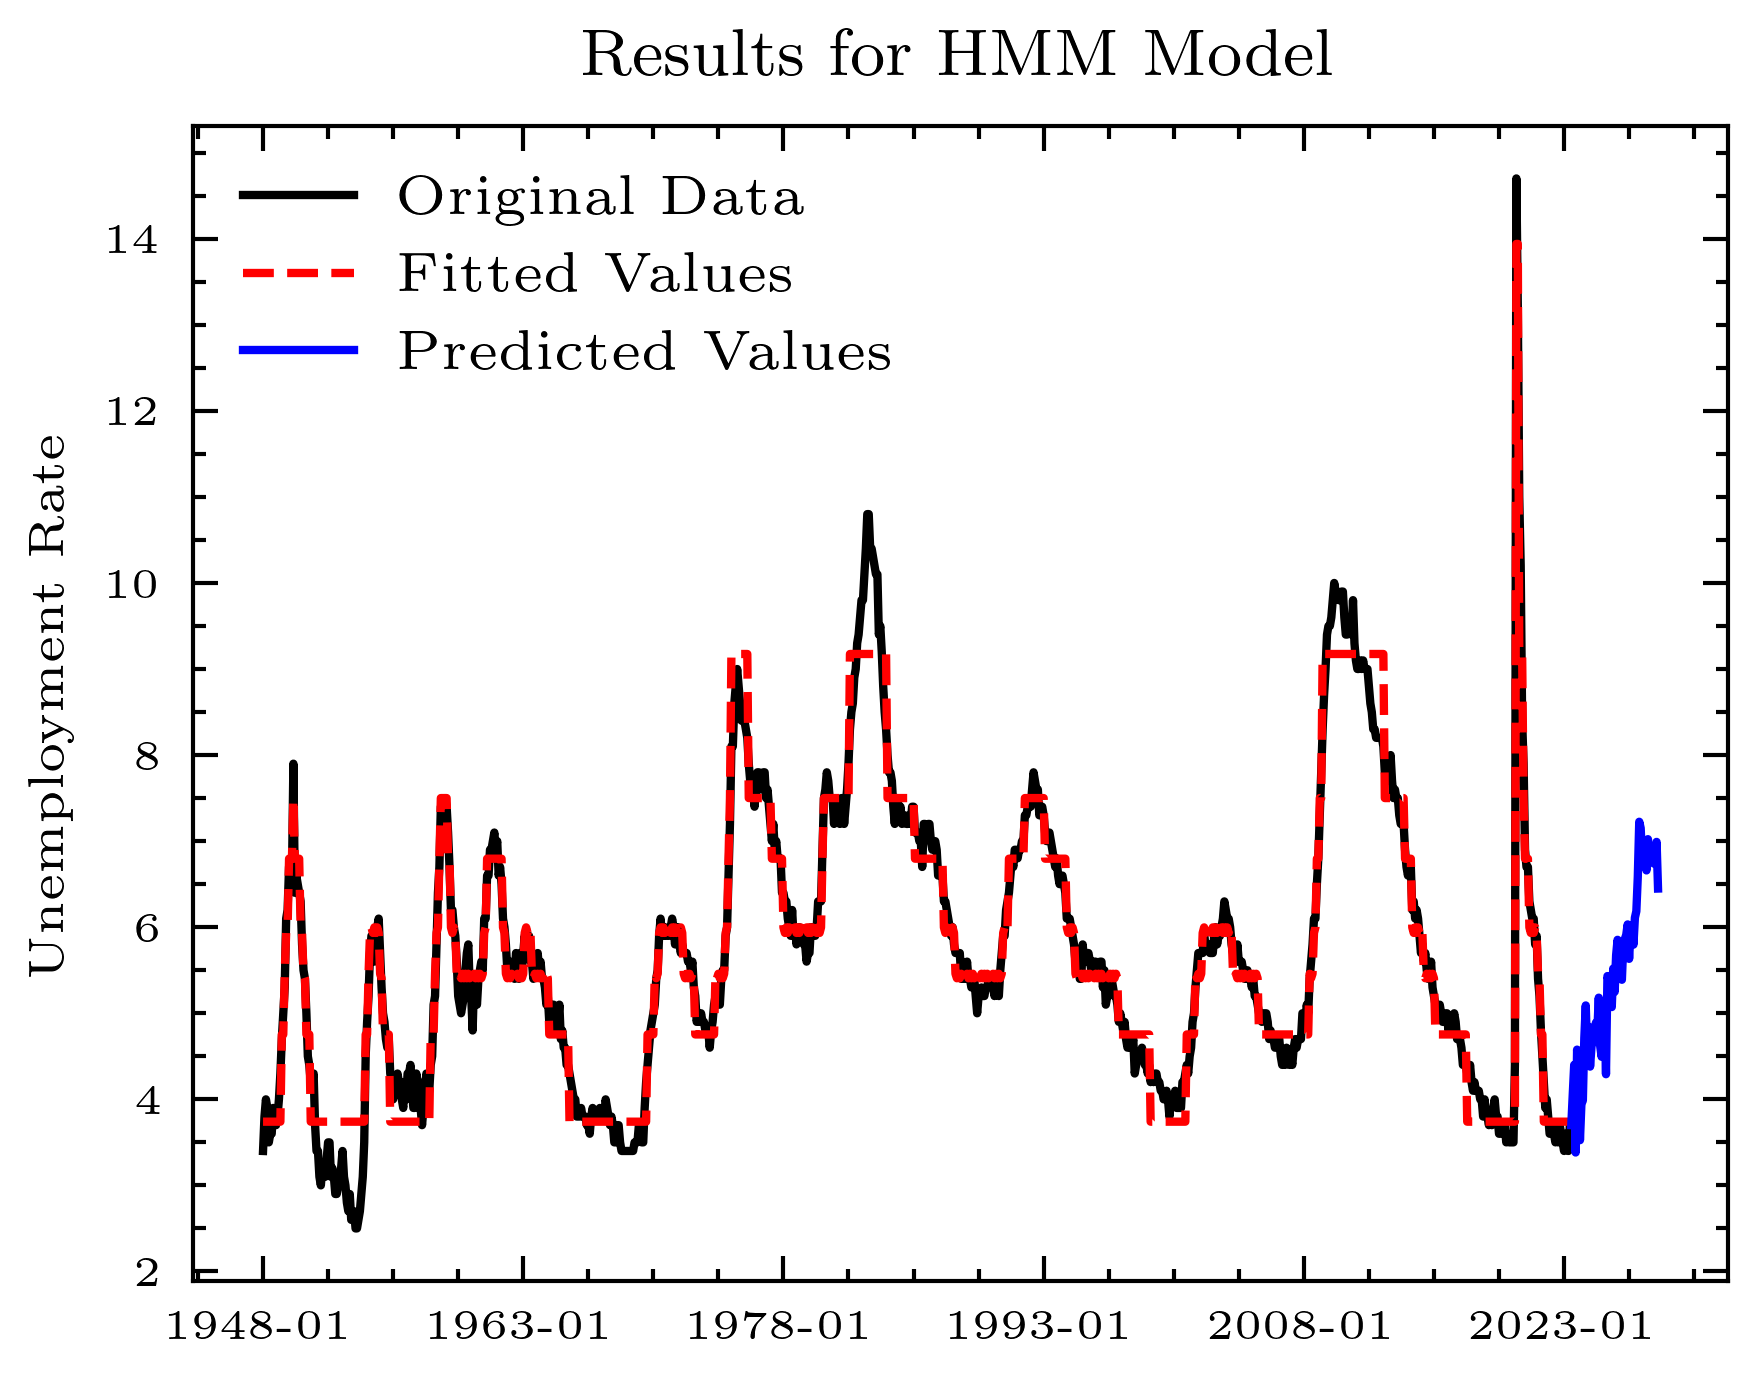

hmmMSE= 0.1224
hmmMADE= 0.2546


<Figure size 1980x1500 with 0 Axes>

In [44]:
#prepare data
data=pd.read_excel(r"C:\Users\LX\Desktop\时间序列\案例分析报告\dataset.xlsx").iloc[:, 1:3]['Value']
train_data=data[:905]
train_data=np.array(train_data).reshape(-1, 1)
#establish HMM
model=hmm.GaussianHMM(n_components=10,n_iter=100)
#fit the model
model.fit(train_data)
#Forecasting the next 60 time steps
predicted_states, _=model.sample(n_samples=60)
predicted_values=predicted_states.flatten()
# visualization
plt.style.use(['science','ieee'])
plt.grid (False)
plt.plot(newdf['Date'],newdf['Value'], label='Original Data')
hidden_states=model.predict(train_data)
hmm_fitted_values=model.means_[hidden_states].flatten()
plt.plot(hmm_fitted_values, label='Fitted Values')
start_value=train_data[-1]
predicted_values=model.sample(n_samples=60, random_state=0)[0].flatten()
hmm_predicted_values=np.concatenate([start_value, predicted_values])
plt.plot(range(len(data),len(data)+len(hmm_predicted_values)), hmm_predicted_values, label='Predicted Values',linestyle='-')
plt.xticks(range(0, 905, 180),rotation=0,fontsize=5)
plt.yticks(fontsize=5)
plt.ylabel('Unemployment Rate',fontsize=6)
plt.legend(fontsize='small')
plt.title('Results for HMM Model',fontsize=8)
plt.savefig('HMM.png', transparent=True,dpi=1000)
plt.show()
plt.clf()
print("hmmMSE=",round(MSE(newdf['Value'],hmm_fitted_values),4))
print("hmmMADE=",round(MADE(newdf['Value'],hmm_fitted_values),4))

## Prophet

13:57:29 - cmdstanpy - INFO - Chain [1] start processing
13:57:29 - cmdstanpy - INFO - Chain [1] done processing


prophetMSE= 2.2197
prophetMADE= 1.16


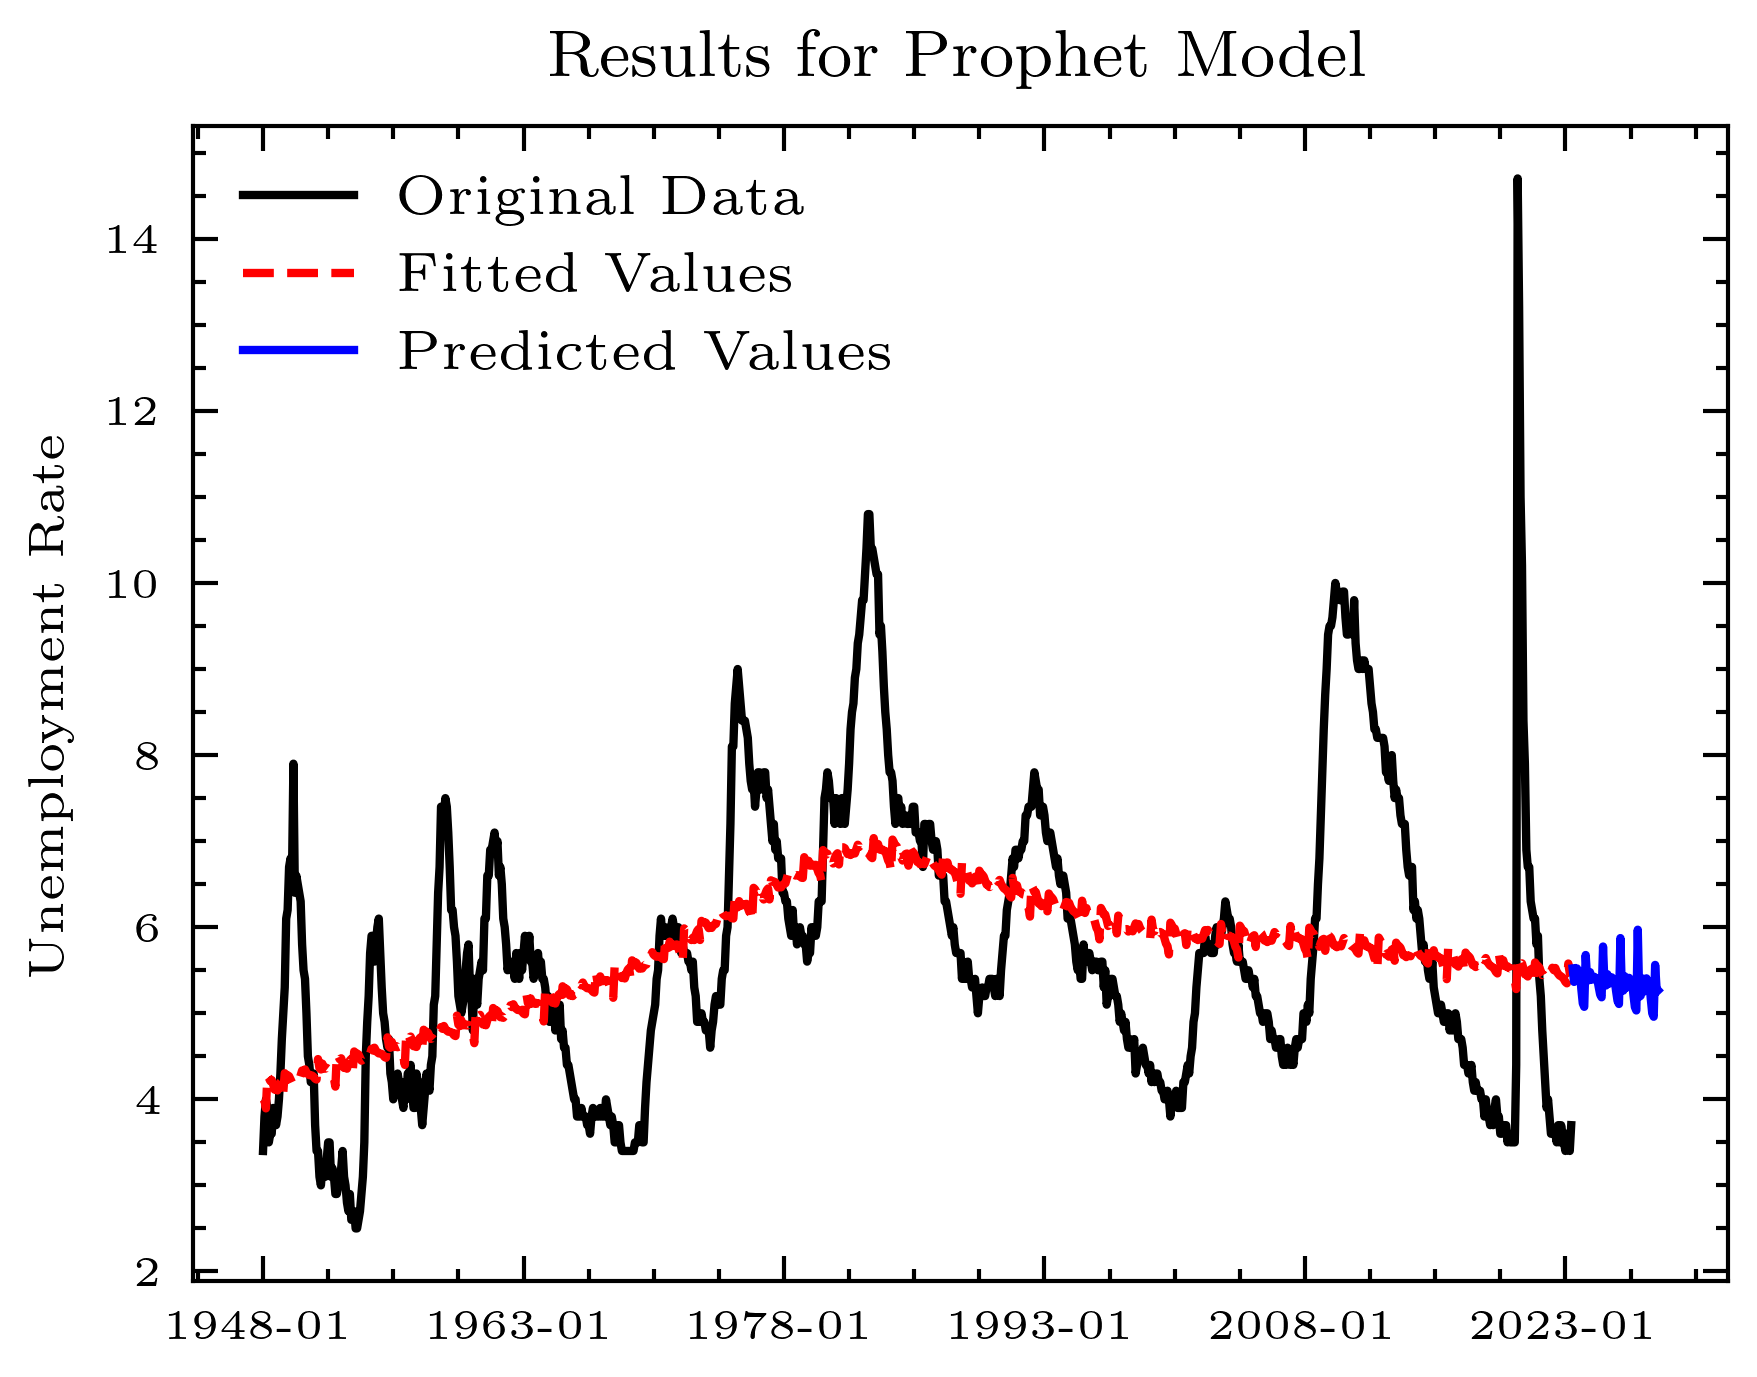

<Figure size 1980x1500 with 0 Axes>

In [43]:
#prepare data
new_column_names={'Date': 'ds', 'Value': 'y'}
data_renamed=newdf.rename(columns=new_column_names)
#train the model
model=Prophet(yearly_seasonality=True,growth='linear')
model.fit(data_renamed)
#adjust the format of data
future=model.make_future_dataframe(periods=60,freq='M')
forecast=model.predict(future)
forecast_df=forecast[['ds','yhat','yhat_lower','yhat_upper']]
prophet_fitted_values=forecast_df.head(905)['yhat']
prophet_predcited_values=forecast_df['yhat'].tail(60)
#model evaluation
print("prophetMSE=",round(MSE(newdf['Value'],prophet_fitted_values),4))
print("prophetMADE=",round(MADE(newdf['Value'],prophet_fitted_values),4))
#visualization
plt.style.use(['science','ieee'])
plt.grid (False)
plt.plot(newdf['Date'],newdf['Value'], label='Original Data')
plt.plot(prophet_fitted_values,label='Fitted Values')
plt.plot(prophet_predcited_values,label='Predicted Values',linestyle='-')
plt.xticks(range(0, 905, 180),rotation=0,fontsize=5)
plt.yticks(fontsize=5)
plt.ylabel('Unemployment Rate',fontsize=6)
plt.legend(fontsize='small')
plt.title('Results for Prophet Model',fontsize=8)
plt.savefig('Prophet.png', transparent=True,dpi=1000)
plt.show()
plt.clf()

## Long Short-Term Memory(LSTM)

In [25]:
#Define a function to observe the training process
def print_history1(history):
    # Plot the training and validation accuracy values.
    plt.style.use(['science','ieee'])
    plt.grid (False)
    plt.plot(history.history['accuracy'],linewidth=1.0,color='b')
    plt.title('Accuracy',fontsize=14)
    plt.xlabel('Epoch')
    plt.legend(['accuracy'])
    plt.savefig('modelaccuracy.png', transparent=True,dpi=1000)
    plt.show()

In [26]:
def print_history2(history):
    plt.style.use(['science','ieee'])
    plt.grid (False)
    plt.plot(history.history['loss'],linewidth=1.0,color='b')
    plt.title('Loss',fontsize=14)
    plt.xlabel('Epoch')
    plt.legend(['loss'])
    plt.savefig('modelloss.png', transparent=True,dpi=1000)
    plt.show()

In [19]:
#predict the current value using the past 20 historical data points
sequence_length=20
#build a simple LSTM model
lstmmodel=Sequential()
lstmmodel.add(LSTM(128,activation='sigmoid',input_shape=(sequence_length,1)))
lstmmodel.add(Dropout(0.3))
lstmmodel.add(Dense(1))
lstmmodel.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])

In [20]:
##prepare data
data=pd.read_excel(r"C:\Users\LX\Desktop\时间序列\案例分析报告\dataset.xlsx").iloc[:,1:3]['Value']
train_data=data[:905]
# Define helper functions to generate training sets and labels
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)
# Set the sequence length and prediction steps.
sequence_length=20
sequence_length=int(sequence_length)
prediction_steps=60
prediction_steps=int(prediction_steps)
# Create training sets and labels.
X_train, y_train=create_sequences(train_data, sequence_length)
X_train=X_train.reshape(885,20,1)

In [21]:
#train the model
history=lstmmodel.fit(X_train, y_train, epochs=500, batch_size=16)
#Perform rolling forecasts using the trained model.
predicted_values=[]
last_sequence=X_train[-1]  # use the last sequence of the training set as a starting point
for _ in range(prediction_steps):
    predicted_value=lstmmodel.predict(last_sequence.reshape(1, sequence_length, 1))
    predicted_values.append(predicted_value[0, 0])
    last_sequence=np.append(last_sequence[1:], predicted_value[0, 0])

Epoch 1/500
885/885 [==============================] - 2s 2ms/step - loss: 5.9260 - accuracy: 0.0192
Epoch 2/500
885/885 [==============================] - 1s 2ms/step - loss: 2.6741 - accuracy: 0.0316
Epoch 3/500
885/885 [==============================] - 1s 2ms/step - loss: 2.3073 - accuracy: 0.0362
Epoch 4/500
885/885 [==============================] - 1s 2ms/step - loss: 1.8005 - accuracy: 0.0328
Epoch 5/500
885/885 [==============================] - 1s 2ms/step - loss: 1.2489 - accuracy: 0.0384
Epoch 6/500
885/885 [==============================] - 1s 2ms/step - loss: 0.7967 - accuracy: 0.0531
Epoch 7/500
885/885 [==============================] - 1s 2ms/step - loss: 0.6606 - accuracy: 0.0599
Epoch 8/500
885/885 [==============================] - 1s 2ms/step - loss: 0.6340 - accuracy: 0.0565
Epoch 9/500
885/885 [==============================] - 1s 2ms/step - loss: 0.6648 - accuracy: 0.0655
Epoch 10/500
885/885 [==============================] - 1s 2ms/step - loss: 0.5881 - accura

885/885 [==============================] - 1s 2ms/step - loss: 0.3240 - accuracy: 0.0814
Epoch 161/500
885/885 [==============================] - 1s 2ms/step - loss: 0.3019 - accuracy: 0.0814
Epoch 162/500
885/885 [==============================] - 1s 2ms/step - loss: 0.3383 - accuracy: 0.0836
Epoch 163/500
885/885 [==============================] - 1s 2ms/step - loss: 0.2673 - accuracy: 0.0904
Epoch 164/500
885/885 [==============================] - 1s 2ms/step - loss: 0.2980 - accuracy: 0.0836
Epoch 165/500
885/885 [==============================] - 1s 2ms/step - loss: 0.3051 - accuracy: 0.0893
Epoch 166/500
885/885 [==============================] - 1s 2ms/step - loss: 0.3036 - accuracy: 0.0825
Epoch 167/500
885/885 [==============================] - 1s 2ms/step - loss: 0.2938 - accuracy: 0.0814
Epoch 168/500
885/885 [==============================] - 1s 2ms/step - loss: 0.3120 - accuracy: 0.0870
Epoch 169/500
885/885 [==============================] - 1s 1ms/step - loss: 0.2935 - a

885/885 [==============================] - 1s 904us/step - loss: 0.2553 - accuracy: 0.0927
Epoch 318/500
885/885 [==============================] - 1s 904us/step - loss: 0.2435 - accuracy: 0.0994
Epoch 319/500
885/885 [==============================] - 1s 949us/step - loss: 0.2406 - accuracy: 0.0927
Epoch 320/500
885/885 [==============================] - 1s 938us/step - loss: 0.2418 - accuracy: 0.0915
Epoch 321/500
885/885 [==============================] - 1s 940us/step - loss: 0.2522 - accuracy: 0.0927
Epoch 322/500
885/885 [==============================] - 1s 959us/step - loss: 0.2640 - accuracy: 0.0949
Epoch 323/500
885/885 [==============================] - 1s 961us/step - loss: 0.2489 - accuracy: 0.0927
Epoch 324/500
885/885 [==============================] - 1s 926us/step - loss: 0.2560 - accuracy: 0.0927
Epoch 325/500
885/885 [==============================] - 1s 925us/step - loss: 0.2407 - accuracy: 0.0904
Epoch 326/500
885/885 [==============================] - 1s 950us/ste

885/885 [==============================] - 1s 926us/step - loss: 0.2164 - accuracy: 0.0960
Epoch 473/500
885/885 [==============================] - 1s 904us/step - loss: 0.2195 - accuracy: 0.0960
Epoch 474/500
885/885 [==============================] - 1s 915us/step - loss: 0.2193 - accuracy: 0.0927
Epoch 475/500
885/885 [==============================] - 1s 915us/step - loss: 0.2319 - accuracy: 0.0960
Epoch 476/500
885/885 [==============================] - 1s 939us/step - loss: 0.2158 - accuracy: 0.0938
Epoch 477/500
885/885 [==============================] - 1s 942us/step - loss: 0.2050 - accuracy: 0.10170s - loss: 0.2423 - accura
Epoch 478/500
885/885 [==============================] - 1s 932us/step - loss: 0.2132 - accuracy: 0.0972
Epoch 479/500
885/885 [==============================] - 1s 972us/step - loss: 0.2451 - accuracy: 0.0904
Epoch 480/500
885/885 [==============================] - 1s 983us/step - loss: 0.2295 - accuracy: 0.0927
Epoch 481/500
885/885 [====================

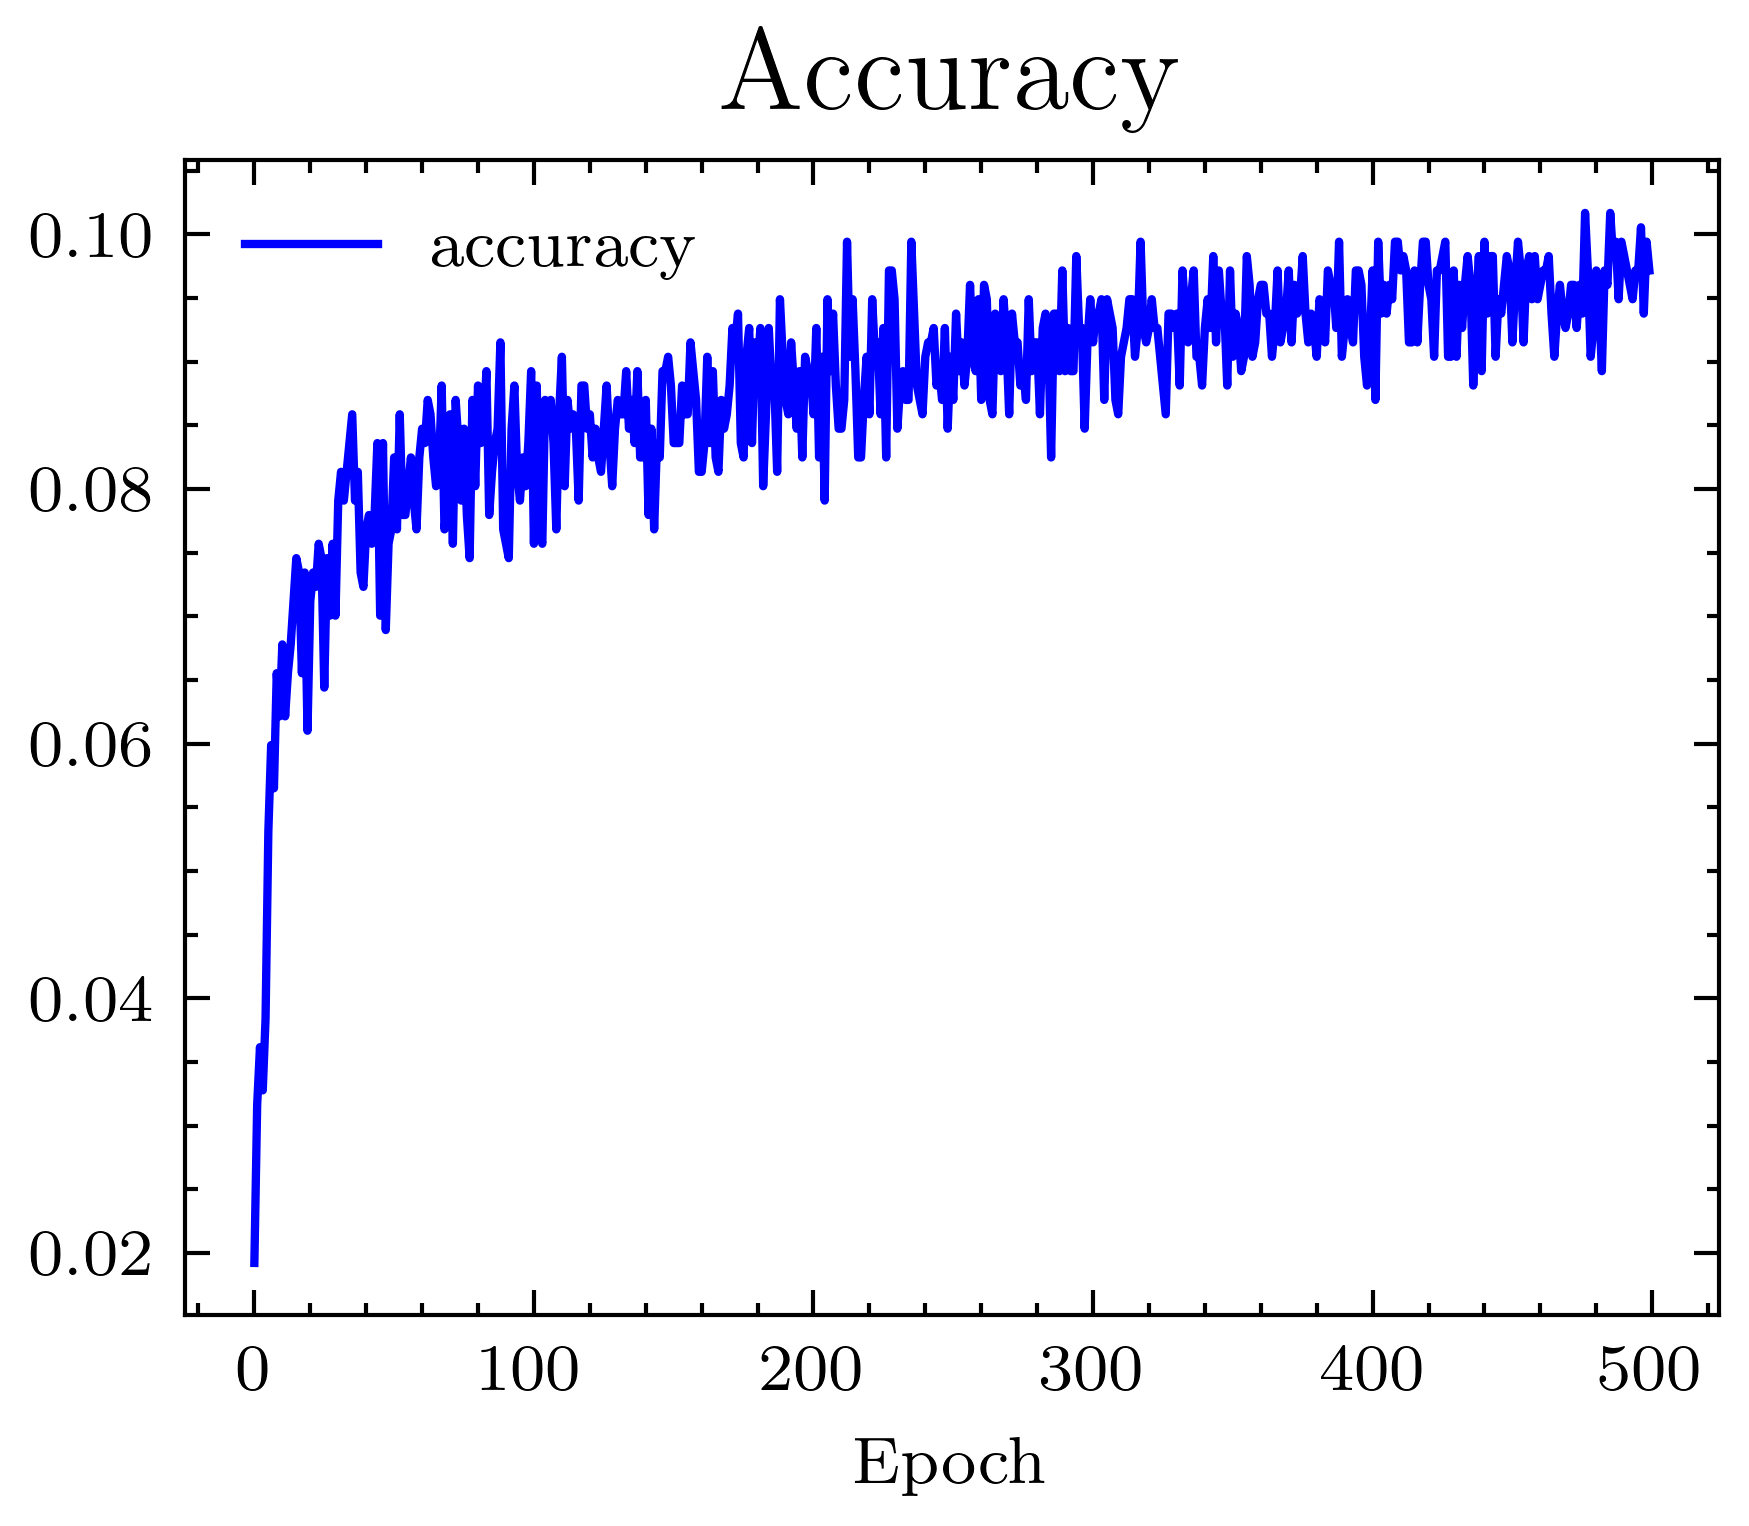

In [27]:
#Observe the training process with the help of the function defined earlier
print_history1(history)

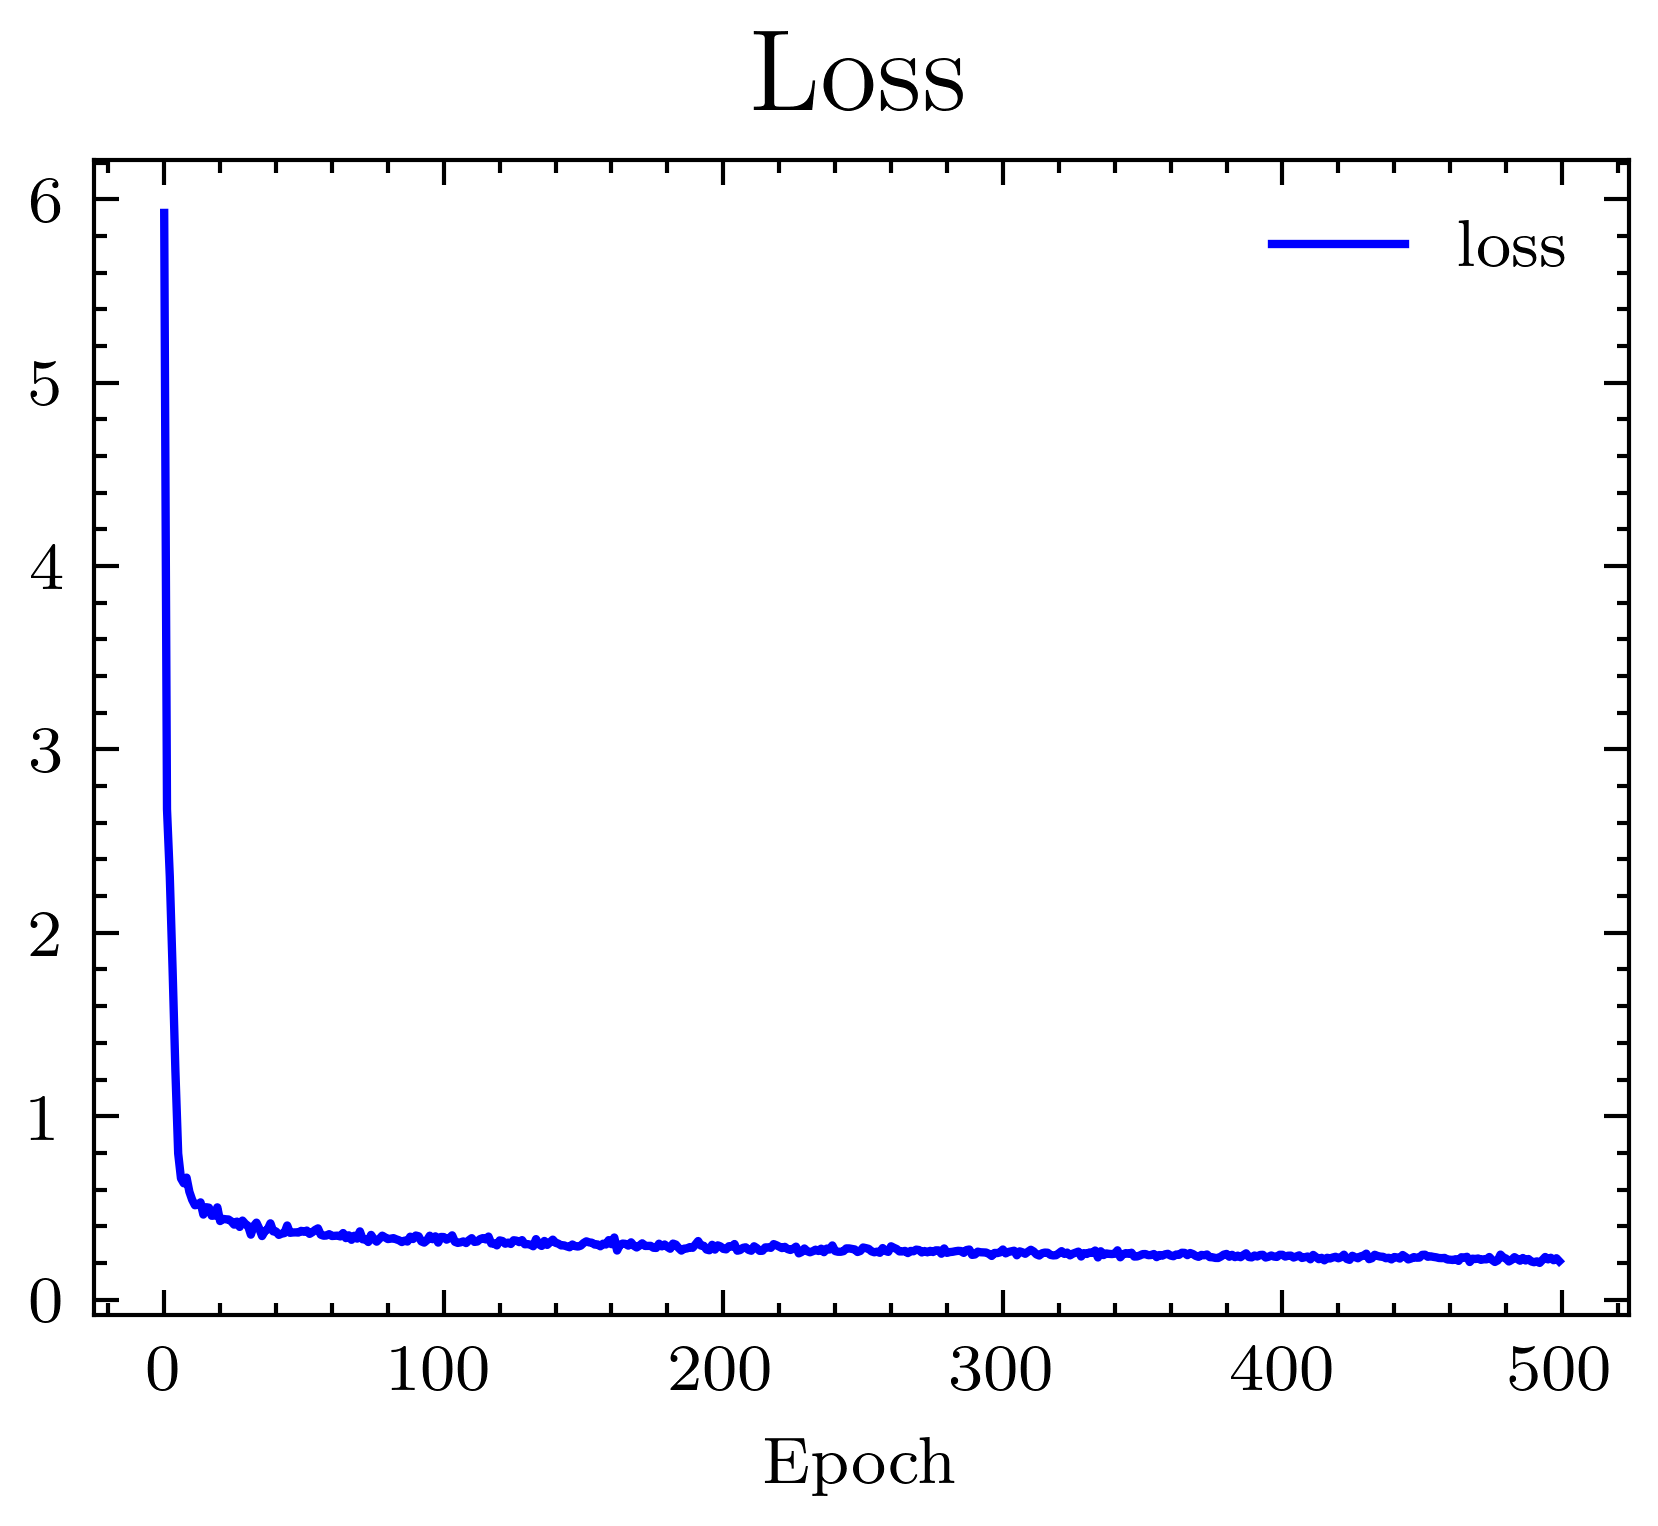

In [28]:
print_history2(history)

lstmMSE= 0.1492
lstmMADE= 0.1535


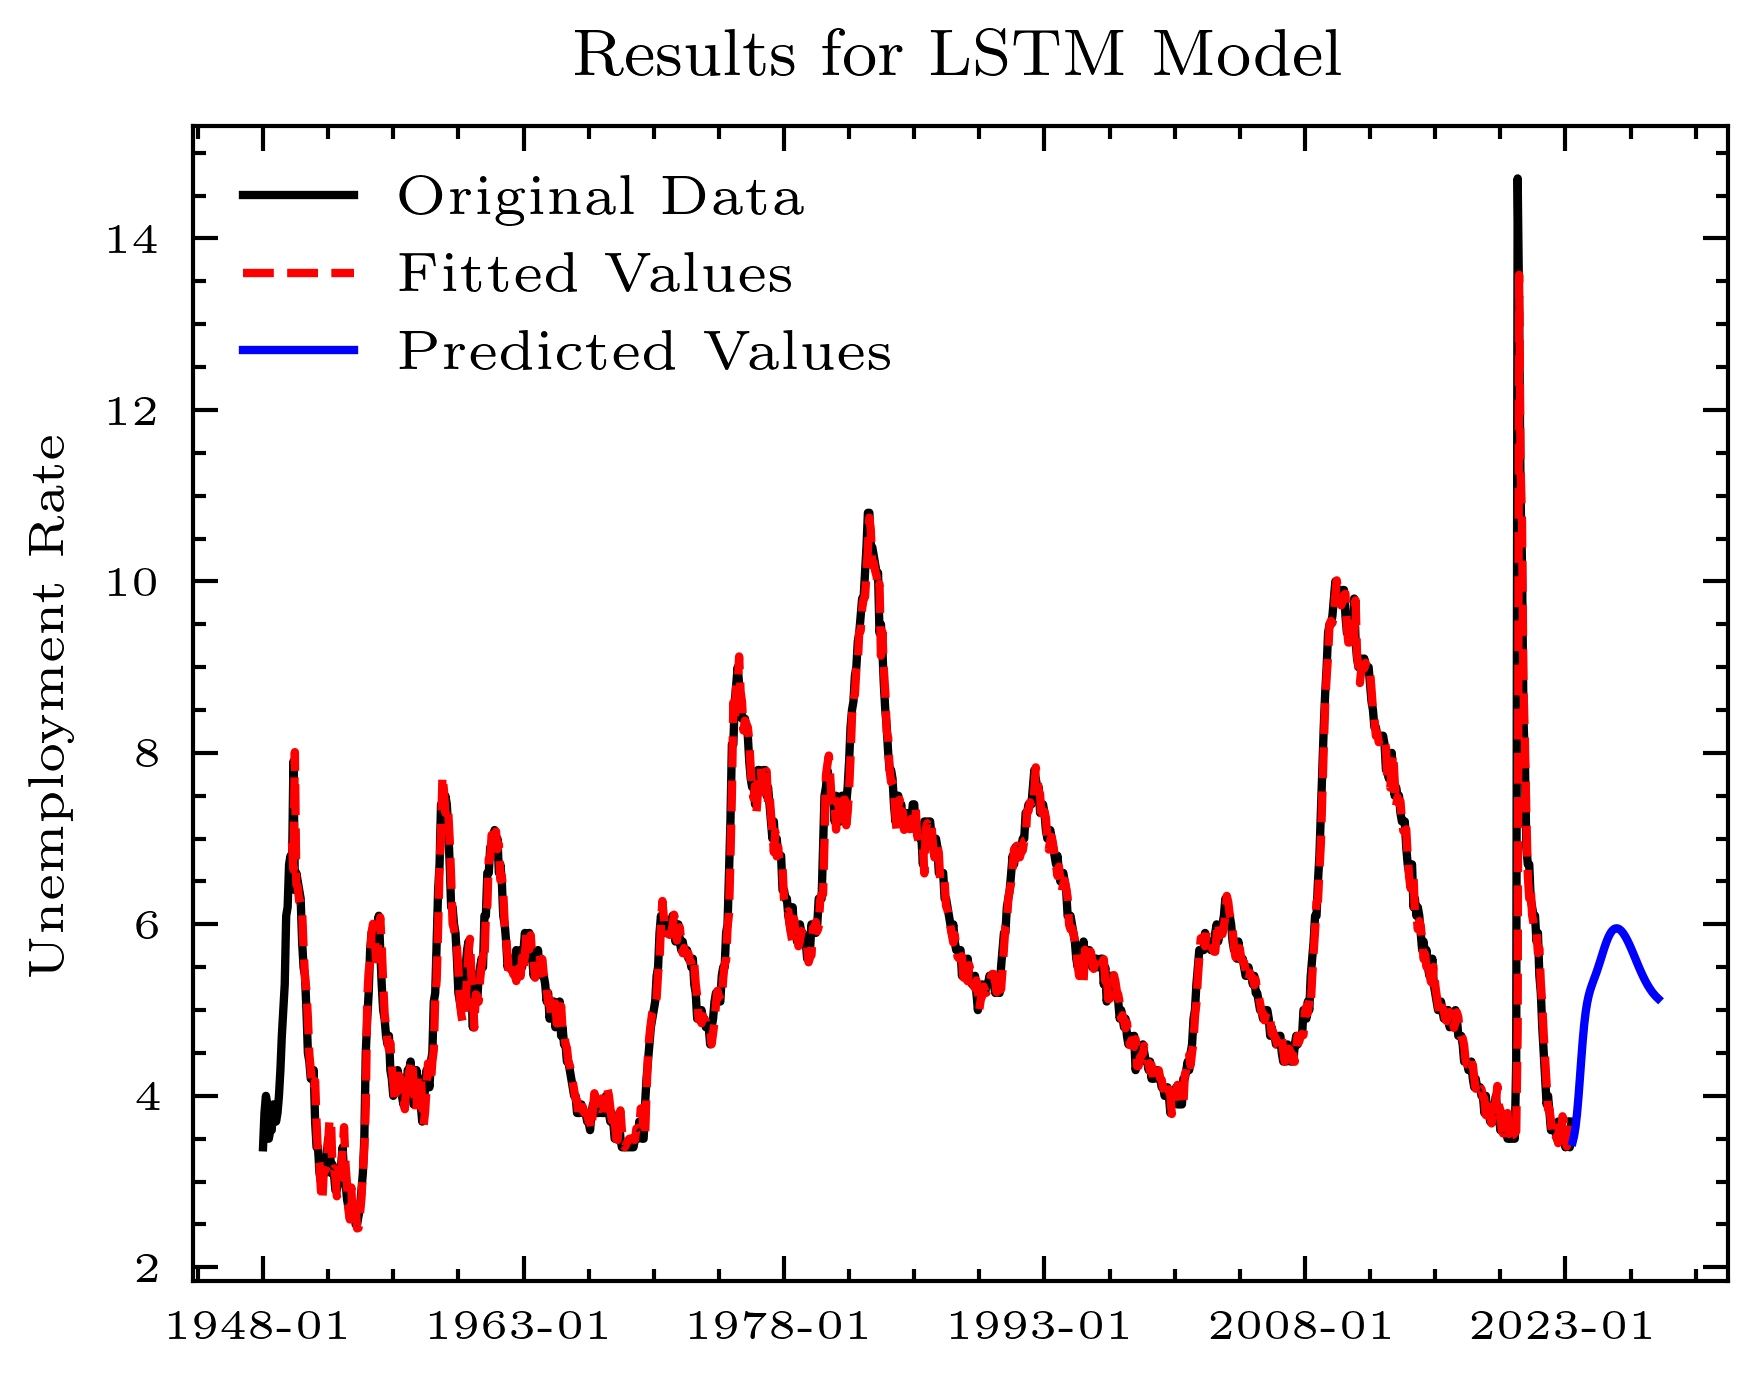

<Figure size 1980x1500 with 0 Axes>

In [42]:
lstm_predicted_values=predicted_values
lstm_fitted_values=lstmmodel.predict(X_train)#Note that there are no fitted values for the first 20 times
#model evaluation
print("lstmMSE=",round(MSE(np.array(newdf['Value'][20:]).reshape(-1,1),lstm_fitted_values),4))
print("lstmMADE=",round(MADE(np.array(newdf['Value'][20:]).reshape(-1,1),lstm_fitted_values),4))
#visualization
plt.style.use(['science','ieee'])
plt.grid (False)
plt.plot(newdf['Date'],newdf['Value'], label='Original Data')
plt.plot(range(20, len(data)),lstmmodel.predict(X_train), label='Fitted Values')
plt.plot(range(len(data), len(data) + len(lstm_predicted_values)),lstm_predicted_values, label='Predicted Values',linestyle='-')
plt.xticks(range(0, 905, 180),rotation=0,fontsize=5)
plt.yticks(fontsize=5)
plt.ylabel('Unemployment Rate',fontsize=6)
plt.legend(fontsize='small')
plt.title('Results for LSTM Model',fontsize=8)
plt.savefig('LSTM.png', transparent=True,dpi=1000)
plt.show()
plt.clf()

## Result Comparison

In [29]:
plt.clf()

<Figure size 1980x1500 with 0 Axes>

In [1]:
##the results of fitted values
plt.style.use(['science','ieee'])
plt.grid (False)
plt.plot(range(0,905),arima_fitted_values,label='ARIMA Model',linewidth=1.0)
plt.plot(range(0,905),hmm_fitted_values,label='HMM Model',linewidth=1.0)
plt.plot(range(0,905),prophet_fitted_values,label='Prophet Model',linewidth=1.0)
plt.plot(range(20,905),lstm_fitted_values,label='LSTM Model',linewidth=1.0)
plt.plot(newdf['Date'],newdf['Value'], label='Original Data',linewidth=1.0,color='orange')
plt.xticks(range(0, 905, 180),rotation=0,fontsize=5)
plt.yticks(fontsize=5)
plt.ylabel('Unemployment Rate',fontsize=6)
plt.legend(fontsize='small')
plt.title('Fitted Values by Four Models',fontsize=8)
plt.savefig('Fourfittedvalues.png', transparent=True,dpi=1000)
plt.show()
plt.clf()

NameError: name 'plt' is not defined

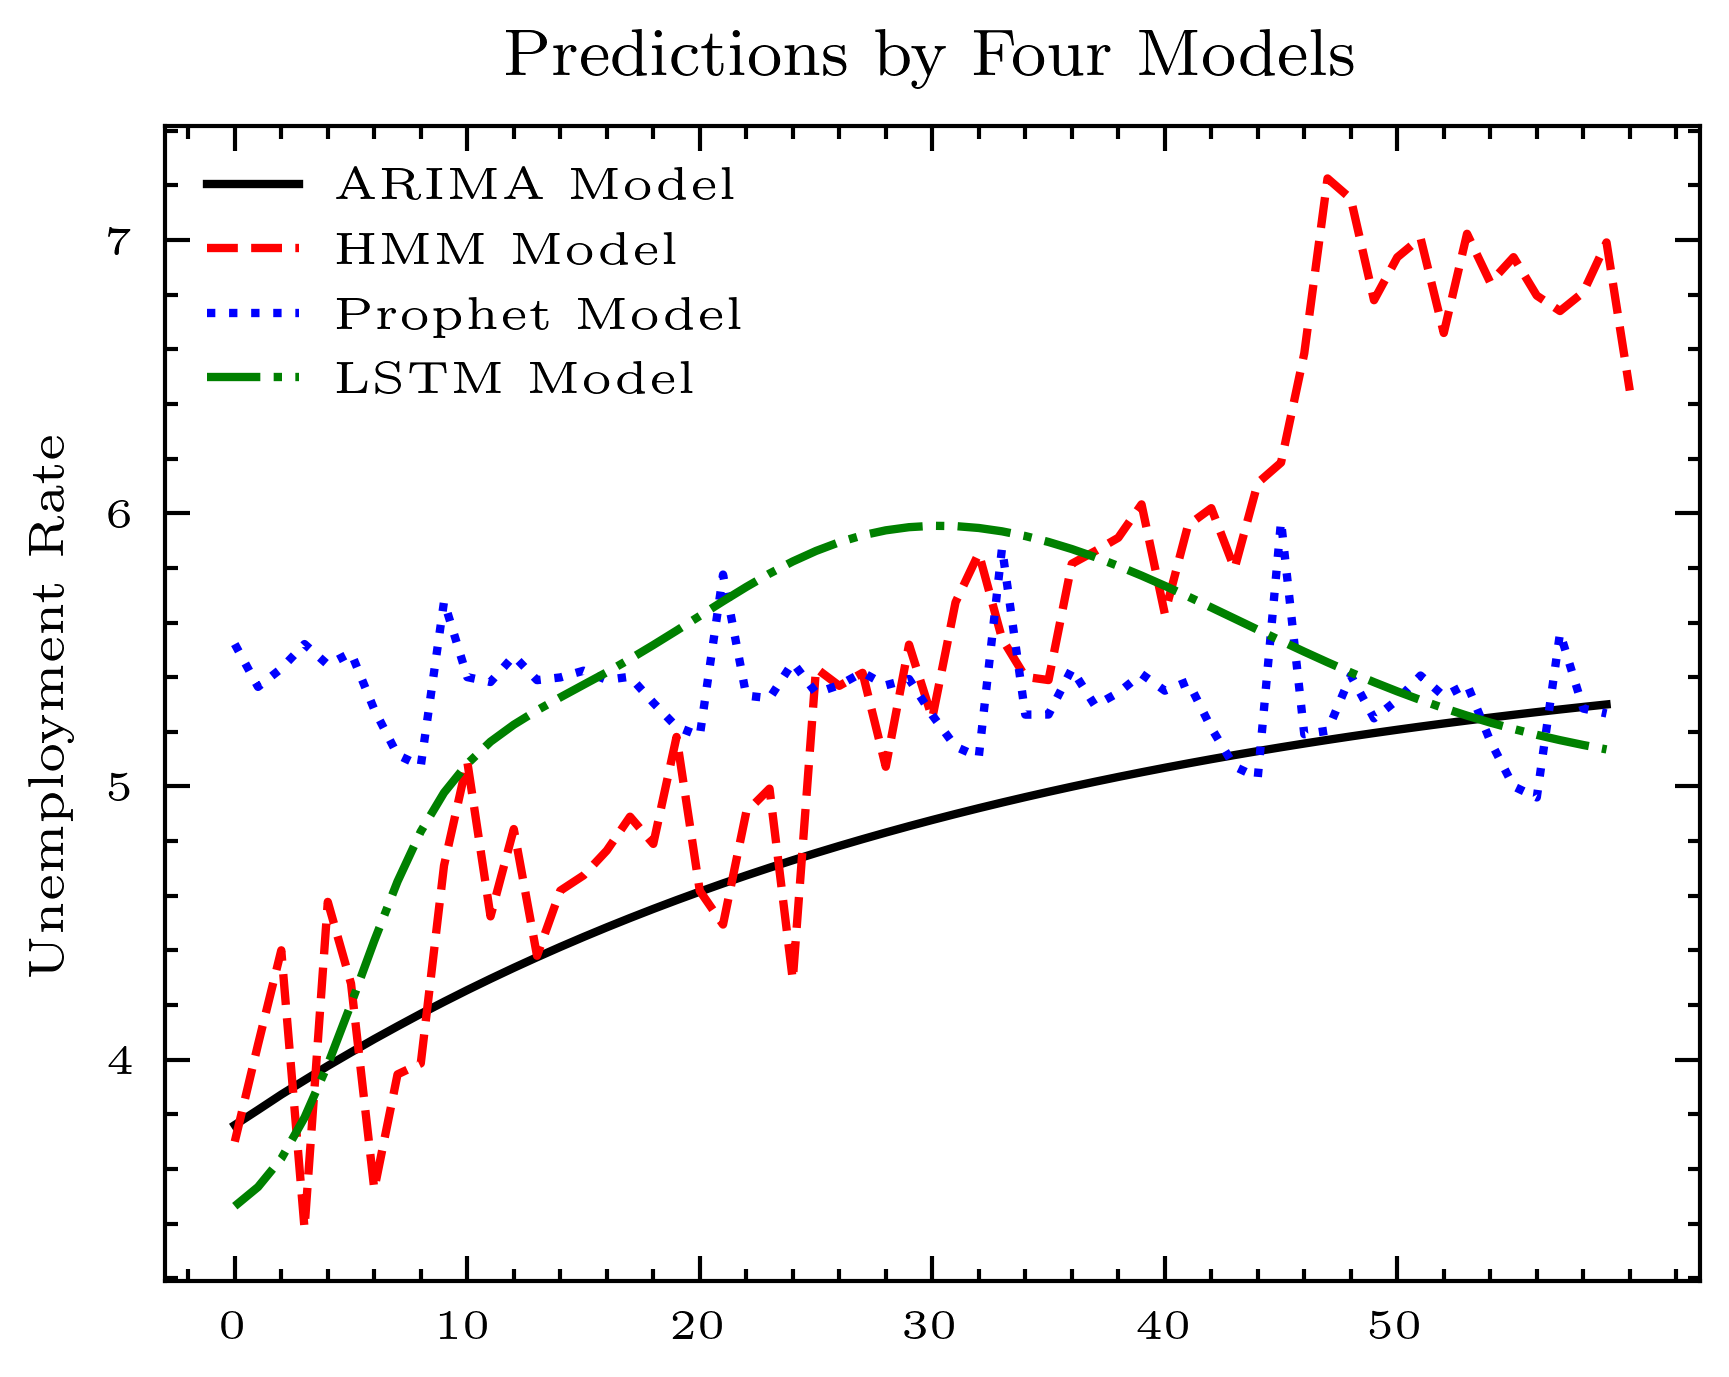

<Figure size 1980x1500 with 0 Axes>

In [46]:
##the result of prediction
plt.style.use(['science','ieee'])
plt.grid (False)
plt.plot(range(0,60),arima_predicted_values,label='ARIMA Model')
plt.plot(range(0,61),hmm_predicted_values,label='HMM Model')
plt.plot(range(0,60),prophet_predcited_values,label='Prophet Model')
plt.plot(range(0,60),lstm_predicted_values,label='LSTM Model')
plt.xticks(range(0, 60, 10),rotation=0,fontsize=5)
plt.yticks(fontsize=5)
plt.ylabel('Unemployment Rate',fontsize=6)
plt.legend(fontsize='x-small')
plt.title('Predictions by Four Models',fontsize=8)
plt.savefig('FourPredictions.png', transparent=True,dpi=1000)
plt.show()
plt.clf()